# Classification of Images with Masks using Machine Learning

The data set from https://www.kaggle.com/rakshana0802/face-mask-detection-data consists of a total of 3833 images (1915 images of people wearing face masks, and 1918 images of people without face masks). The goal of this project is to train sufficient data with various machine learning algorithms and analyze/compare the accuracy and efficiency of each classification method.

## Data Inspection and Cleaning

The first problem that I faced was that the images in the data set came in different sizes (some larger than others), file types (.PNG, .JPG, .JPEG), modes (images come in P, RGB, and RGBA modes). The difference in file types and modes is especially prevalent among images of people with face masks (more details in `image_analysis.py`). Hence, I wrote a program `img2vec.py` that transforms all images to a standard size (128 $\times$ 128), file type (.jpg), and mode (RGB). The so-called "standard" can be easily changed at the top of the program in `img2vec.py`. The output of this data is a `mask.csv` file, where the first column in the file corresponds to the class of each image (with or without mask) and the rest of the columns corresponds to the pixel value in a specific row/column of the transformed images.

Note that I have also written the program `vec2img.py` that allows the viewing of the transformed images.

## Machine Learning Algorithms Used:

* Support Vector Machines

* Classification via Singular Value Decomposition (SVD) Properties

* Logistic Regression

* Linear Discriminant Analysis (LDA)

* Random Forest/Decision Trees

* Neural Network

## Code to import `mask.csv` into a dataframe and sort into training and test data

In [36]:
PERCENTAGE_OF_TRAIN = 0.8

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# import mask.csv
full_data = pd.read_csv('mask.csv', header = 0)

# split into two separate data frames by images with and without masks
with_mask = full_data[full_data.with_mask == 'Yes']
without_mask = full_data[full_data.with_mask == 'No']

(train_x_withmask, test_x_withmask, train_y_withmask, test_y_withmask) = train_test_split(with_mask.iloc[:,1:], with_mask.iloc[:,0], train_size = PERCENTAGE_OF_TRAIN, test_size = 1 - PERCENTAGE_OF_TRAIN, random_state = 1)
(train_x_withoutmask, test_x_withoutmask, train_y_withoutmask, test_y_withoutmask) = train_test_split(without_mask.iloc[:,1:], without_mask.iloc[:,0], train_size = PERCENTAGE_OF_TRAIN, test_size = 1 - PERCENTAGE_OF_TRAIN, random_state = 1)

train_x = np.vstack((train_x_withmask, train_x_withoutmask))
train_y = pd.concat([train_y_withmask, train_y_withoutmask], axis = 0).reset_index(drop = True)
train_y = np.array(train_y)

test_x = np.vstack((test_x_withmask, test_x_withoutmask))
test_y_true = pd.concat([test_y_withmask, test_y_withoutmask], axis = 0).reset_index(drop = True)
test_y_true = np.array(test_y_true)

### Code to plot confusion matrices later on

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def plot_confmat(clf, X, y):
    (fig, (ax1, ax2)) = plt.subplots(1,2, figsize=(10, 5))
    disp1 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = None, ax = ax1)
    disp2 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = 'true', ax = ax2)
    disp1.ax_.set_title('Non-normalized Confusion Matrix')
    disp2.ax_.set_title('Normalized Confusion Matrix')
    disp2.im_.set_clim(0,1)
    return disp1.confusion_matrix

### Code to analyze classification result later on

In [4]:
classification_result = {}

## Support Vector Machines (SVM)

The general idea of how a Support Vector Machine works is that an $n-1$ dimension hyperplane is "drawn" on an $n$ dimension "plot" to split the data into two (or more) classes. It is constructed such that the distance between each data point and the hyperplane is at its furthest. The hyperplane can be expressed as the following equation:
$$w^T x + b = 0$$
where $w \in \mathbb{R}^{n-1}$ and $b \in \mathbb{R}$. The data points with parameter values $x_i$ where $w^T x_i + b < 0$ will be classified into one class and the data points that give us $w^T x_i + b > 0$ will be classified into the other class. Running the SVM when our data points are linearly separable (ie. data points can be classified by drawing a straight hyperplane) is extremely simple. Problems arise when data points aren't linearly separable, which is the case for most classification problems.

The simple solution when the data points are not linearly separable is to simply increase the dimensions of the data set to a point where our data is linearly separable. However, this simple solution can be very time and energy consuming, especially when we have more than 10,000 parameters in this case. To tackle this problem, we can use what is called "kernel tricks".

By definition, "a function that takes as inputs vectors in the original space and returns the dot product of the vectors in the feature space is called a kernel function". In other words, if we have $x,z \in X$ and the map $\phi: x \rightarrow \mathbb{R}^N$ then 
$$k(x,z) = \langle \phi(x), \phi(z) \rangle$$
is a kernel function. (The Kernel Trick in Support Vector Classification, Towards Data Science)

The above definition and function will be the key to solving non-linear classification problems. 

Note that the solution of the dual problem can is always in the following form (refer to Aarti Singh's slides for better explanation):
$$w^* = \sum_{i = 1}^{N} \alpha_i y_i x_i$$
where $N$ is the number of data points used to run the SVM and $y_i$ is the class (either 1 or -1) of data $i$. Recall the hyperplane equation that was previously mentioned, we have now found the solution $w^*$ that gives us the separation hyperplane for the SVM classification. Substituting $w^*$ into the hyperplane equation, we get 
$$\sum_{k = 1}^{N} \alpha_k y_k (x_k^T x) + b$$

Now, we can make predictions with the above equation. Just like before, for a datapoint $x_i$, if $\sum_{k = 1}^{N} \alpha_k y_k (x_k^T x_i) + b > 0$, we will assign it to one of the class, and if $\sum_{k = 1}^{N} \alpha_k y_k (x_k^T x_i) + b < 0$ we will assign it to the other. Here is where the kernel trick comes into play. We want to map the input vector $x_i$ with $x_k$ into a feature space, and we can do so by making the following tweak into the equation:
$$\sum_{k = 1}^{N} \alpha_k y_k (\phi(x_k)^T \phi(x_i)) + b$$

This then gives us
$$\sum_{k = 1}^{N} \alpha_k y_k \langle \phi(x_k), \phi(x_i)\rangle + b \text{ or } \sum_{k = 1}^{N} \alpha_k y_k k(x_k, x_i) + b$$

The same classification decision is done to predict the classes of each test data. 

The next question that generally arises is: What is $k(x,z)$ or $\phi (x)$? This will be answered in each of the following subsections.

### Linear Kernel

In this simple case, $k(x,z) = x^T z$, which is equivalent to not using a kernel trick.

The code below is used to run SVM with a linear kernel. 

Time taken: 224.14 seconds


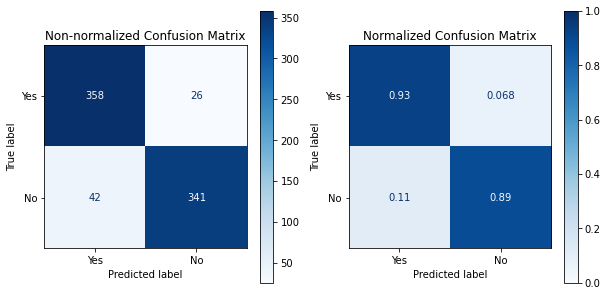

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import time

start = time.time()
classifier = SVC(kernel = 'linear', C = 1)
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Linear'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

The change in the regularization parameter `C` does not change the results at all. However, there are slight differences in the time taken to complete the classification tasks. 

On the other hand, it seems that standardizing the variables (pixels of images in this case) does help improve the true positive rate very slightly, but the overall error rate has increased as well. Hence, standardizing the variables in this case is not a good option.

### RBF Kernel

In this case, $k(x,z) = \exp (- \gamma ||x - z||^2)$, where $\gamma > 0$.

The code below is used to run SVM with an RBF kernel.

Time taken: 308.25 seconds


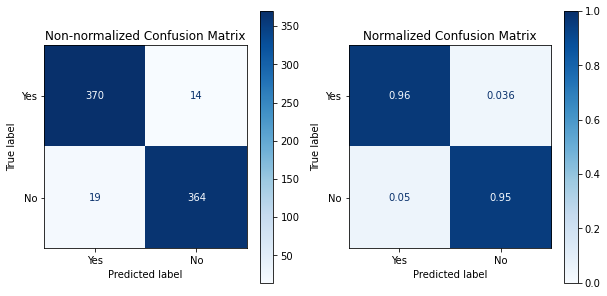

In [6]:
start = time.time()
classifier = SVC(kernel = 'rbf', cache_size = 500, C = 10)
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - RBF'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

The change in the regularization parameter `C` in this case results in a more significant difference. In this case, setting `C = 10` produces the best results. However, the time taken to produce such results is still quite long.

On the other hand, a user from StackExchange (link at end of document) have stated that if there were any doubts on the type of kernel to use, and that there isn't much time to experiment with each model, using the RBF kernel is the way to go as it is one of the (if not the) most robust kernel for SVM. This particular experimentation seems to justify the statement.

### Polynomial Kernel Degree 2

In the next two cases, we have $k(x,z) = (x^T z + c)^d$ to be our kernel function, where $c$ is a constant that can be added, and $d$ is degree of the polynomial. In this current case, $d = 2$, while the next case is set to be $d = 3$.

The code below is used to run SVM with a polynomial kernel of degree 2.

Time taken: 216.39 seconds


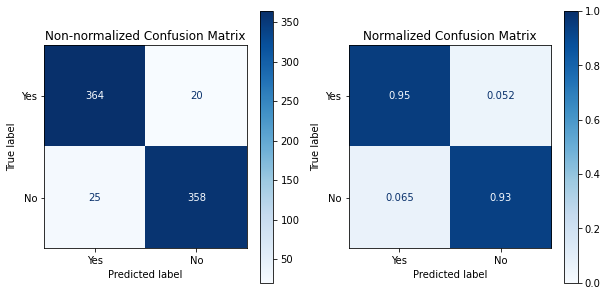

In [7]:
start = time.time()
classifier = SVC(kernel = 'poly', degree = 2)
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Degree 2'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

### Polynomial Kernel Degree 3

The code below is used to run SVM with a polynomial kernel of degree 3.

Time taken: 200.89 seconds


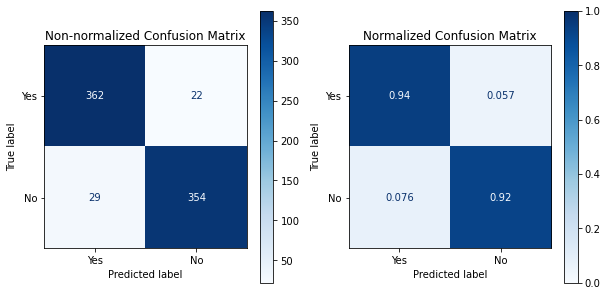

In [8]:
start = time.time()
classifier = SVC(kernel = 'poly', degree = 3, cache_size = 500)
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Degree 3'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

Running the SVM classifier with a polynomial kernel is significantly faster that the RBF kernels, yet the error rate produced is not too bad either (slightly larger that that of the RBF kernel). For this data set, the polynomial kernel of degree 2 is chosen over that of degree 3 due to its better performance.

In the case where computing time is a significant factor, the polynomial kernel can be chosen over the RBF kernel as the preferred choice of classifier.

### Sigmoid Kernel

In this case, $k(x,z) = \tanh(\alpha x^T z + c)$.

The code below isused to run SVM with a sigmoid kernel.

Time taken: 251.17 seconds


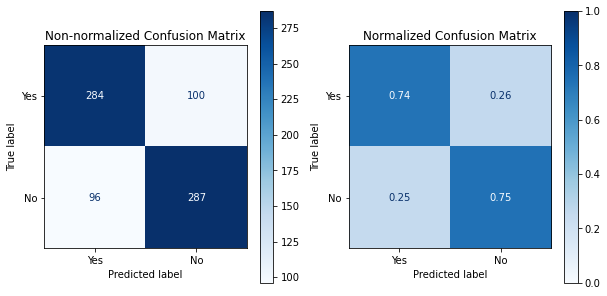

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start = time.time()
classifier = make_pipeline(StandardScaler(), SVC(kernel = 'sigmoid'))
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

classification_result['SVM - Sigmoid'] = {'Time' : time_taken,
                                      'True Positive' : tp,
                                      'True Negative' : tn,
                                      'False Positive' : fp,
                                      'False Negative' : fn}

print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

The SVM classifier fares worst with the sigmoid kernel. Its accuracy is far lower than when using any of the other SVM kernels.

## Classification via Singular Value Decomposition properties

We now move on to classifying the images via properties of SVD. 

The function below is used to separate the training data into two matrices, one for images of class 'Yes' and the other for images of class 'No'. Then, the function returns the SVD matrices of each class matrix.

In [31]:
import scipy as sc

def classify_svd_training(train_mat, train_class):
    X = train_mat.T
    y = train_class.T
    
    U = [[], []]
    S = [[], []]
    V = [[], []]
    for i, class_val in enumerate(['Yes', 'No']):
        index = (y == class_val)
        matrix = X[:, index]
        (U[i], S[i], V[i]) = sc.linalg.svd(matrix, full_matrices = False)
    return (U, S, V)        

The function below used to classify our test data runs the following:

1) We take a test data point and convert it into a vector. Let's call this the vector $b$.

2) After performing SVD on the training data set in the previous section, we get the following:

$$A_i = U_i \Sigma_i V_i^T$$

* $A_i$ is the $m \times n$ training data matrix of class $i$ ($m$ represents the number of pixels in the image and $n$ represents the number of training data). Note that the value of $m$ is constant for all images since we have already transformed each image to a standard size. 

* $U_i$ is an $m \times r$ matrix where each column is orthonormal to one another.

* $\Sigma_i$ is an $r \times r$ matrix where the diagonals are singular values of $A_i$. The singular values in $\Sigma_i$ is ordered in descending order in the diagonals of the matrix.

* $V_i$ is an $n \times r$ matrix where each column is orthonormal to one another.

Now, we can think of the SVD of $A_i$ as organizing the data in the matrix $A_i$ in the sense that the most important components of $A_i$ (or the important details of images of class $i$) are arranged in the first few columns of $U_i, \Sigma_i, V_i$. On the other hand, the least important components of $A_i$ (or the white noises in the images of class $i$) are arranged in the last few columns of $U_i, \Sigma_i, V_i$. 

With this in mind, we want to select $k$ columns of data from $U_i$ to perform our classification. Let's call this version of $U_i$ with only $k$ columns as $U'_i$. We now want to find the vector $x$ such that 

$$U'_i x = b$$

However, since $U'_i$ is not invertible, we get $x$ by solving the normal equation

$$({U'_i}^T U'_i) x = {U'_i}^T b$$

After we manage to obtain $x$, we want to find the norm of the residual vector $r_i = b - U'_i x$.

3) Assuming we ran part (2) with the training matrix for the class 'Yes', run part (2) again with the training matrix for the class 'No' (or vice versa). We should now have the norms of both residual vectors $r_i$. Compare the norms and classify the test data point to the class with the smaller residual norm. Ie. if $||r_{Yes}|| < ||r_{No}||$ then we classify the test data point into the class 'Yes'.

4) Repeat the steps in parts (1) to (3) for each of the test data points. We now have our set of predictions and can compare them with their actual classes.

In [32]:
def classify_test(test_mat, n, U):
    X = test_mat.T
    test_size = X.shape[1]
    classification = []
    for i in range(test_size):
        b = X[:, i]
        resnorm = np.empty(2)
        for j in range(2):
            A = U[j][:,:n]
            x = np.linalg.inv(A.T @ A) @ A.T @ b
            res = b - A @ x
            resnorm[j] = np.linalg.norm(res, 2) / np.linalg.norm(b, 2)
        if resnorm[0] < resnorm[1]:
            classification.append('Yes')
        else:
            classification.append('No')
    return classification

The code below is used to find the SVD of both class matrices.

Note that in the following code, we split our training data into two: training (80\%) and validation (20\%) data. The reason for doing this is because we will be experimenting with different number of singular values to classify the images. In doing so we will need to know the classification accuracies of the "test" data and the corresponding number of singular values used. The number of singular values ($k$) that produces the best classification predictions will then be used to predict the real test data. This way, we know for sure that $k$ singular values will definitely produce some of the best possible predictions on the test data. 

Conversely, if we were to not have a validation data set, and find our best value $k$ based solely on testing with the real test data, it is hard to ensure that that value of $k$ produces the best possible generalized predictions instead of coincidently obtaining a high accuracy value (especially in the case where the accuracy vs $k$-singular values graph fluctuates a lot).

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# splitting train data into train + validation data
(svd_train_x, svd_val_x, svd_train_y, svd_val_y) = train_test_split(train_x, train_y, train_size = 0.8, test_size = 0.2, random_state = 1)

start = time.time()
(train_U, train_S, train_V) = classify_svd_training(svd_train_x, svd_train_y)
end = time.time()
time_taken = end - start
svd_train_time = time_taken

print('Time taken:', round(time_taken, 2), 'seconds')

Time taken: 22.13 seconds


### Magnitude of Singular Values of both classes

The following figures are plotted to give us an idea of the range of values of $k$ we should use to form $U'_i$. Recall that choosing a $k$ too small means that we miss out on important components of the training images and can negatively impact classification accuracy. Similarly, selecting a $k$ too large means that we include unnecessary components and white noise of the training images into our classifications, which can lower our predictive accuracy as well.

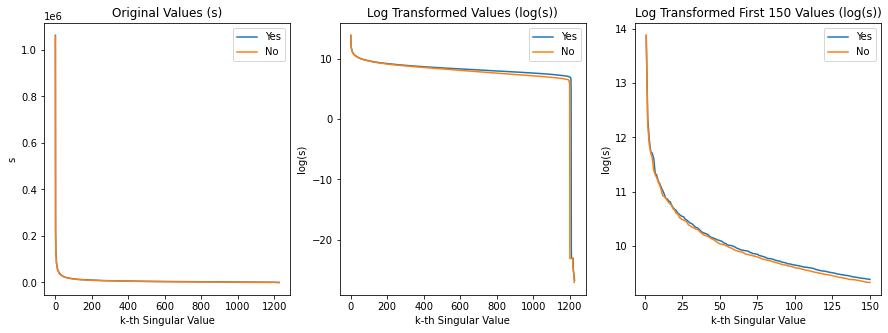

In [13]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))

x1 = list(range(1,len(train_S[0])+1))
y1 = train_S[0]
ax[0].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = train_S[1]
ax[0].plot(x2, y2, label = 'No')

ax[0].set_xlabel('k-th Singular Value')
ax[0].set_ylabel('s')
ax[0].title.set_text('Original Values (s)')
ax[0].legend()

x1 = list(range(1,len(train_S[0])+1))
y1 = np.log(train_S[0])
ax[1].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = np.log(train_S[1])
ax[1].plot(x2, y2, label = 'No')

ax[1].set_xlabel('k-th Singular Value')
ax[1].set_ylabel('log(s)')
ax[1].title.set_text('Log Transformed Values (log(s))')
ax[1].legend()

x1 = list(range(1,151))
y1 = np.log(train_S[0][:150])
ax[2].plot(x1, y1, label = 'Yes')

x2 = list(range(1, 151))
y2 = np.log(train_S[1][:150])
ax[2].plot(x2, y2, label = 'No')

ax[2].set_xlabel('k-th Singular Value')
ax[2].set_ylabel('log(s)')
ax[2].title.set_text('Log Transformed First 150 Values (log(s))')
ax[2].legend()

plt.show()

As we can see in the first figure above, the change in magnitude of the singular values is so large that it is hard to tell which value of $k$ we should choose. 

We then proceeded to take the natural log of each singular value and plot the same figure. The results (shown in the middle figure) shows that there is a sharp dip at around 1200. This means that the singular values occurring after 1200 all correspond to white noises. Additionally, we also see a huge change in the magnitudes of singular values at around 100. 

This brings us to the last figure on the right. In this case, we can see that there is no straightforward way to tell which exact value of $k$ to choose. Hence, I have decided to run the predictions with $k = 5, 10, 15, \ldots, 400$ below and plot a figure of accuracy vs prediction time based on the different values of $k$. 

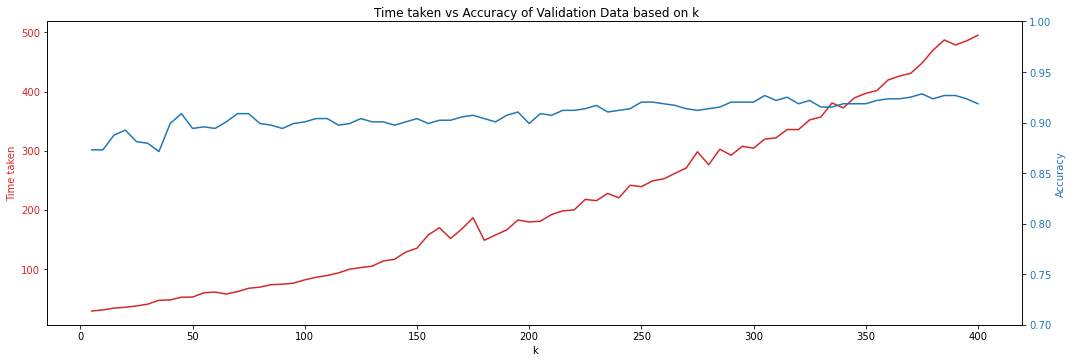

In [14]:
time_taken = []
accuracy = []
n = list(range(5,401,5))

for i in n:
    start = time.time()
    val_y_pred = classify_test(svd_val_x, i, train_U)
    end = time.time()
    time_taken.append(round(end - start, 2) + svd_train_time)
    confmat = confusion_matrix(svd_val_y, val_y_pred, labels = ['Yes', 'No'])
    acc = (confmat[0][0] + confmat[1][1]) / np.sum(confmat)
    accuracy.append(acc)

fig, ax1 = plt.subplots(figsize = (15,5))

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('Time taken', color=color)
ax1.plot(n, time_taken, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(n, accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.7,1])

fig.suptitle('Time taken vs Accuracy of Validation Data based on k', y = 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see in the figure above, the time taken to predict increases exponentially as the value of $k$ increases. This is accompanied by slight increase or decrease in accuracy. In this case, we can say that when $k = 545$, we have our most accurate prediction using this classification method. However, when $k = 155$, we seem to get a similar result, but at a significantly shorter amount of time.

Overall, if we do not have the luxury to run the above code to find the accuracy of each $k$, it is best to just randomly select a $k$-value between 150 and 200 as the prediction accuracies between those values start to stabilize (less fluctuation) and take a relatively short amount of time too, as shown below.

#### Training with best model ($k$ = 375)

Classifying test data with k = 375 singular values:
Time taken: 518.77 seconds


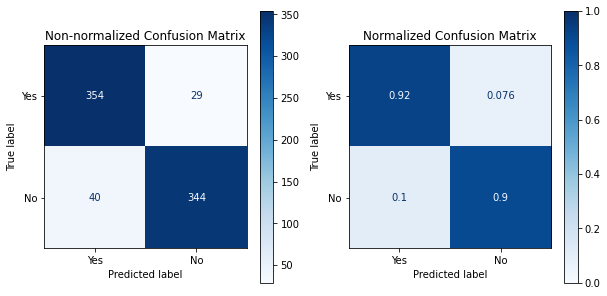

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Number of singular values (k) used that produces maximum prediction accuracy on validation data
k_singularval = (accuracy.index(max(accuracy)) + 1) * 5
varname = 'SVD - ' + str(k_singularval)
print("Classifying test data with k =", k_singularval, "singular values:")

# classifying test data
start = time.time()
test_y_pred = classify_test(test_x, k_singularval, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

# plotting results in confusion matrix
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result[varname] = {'Time' : svd_train_time + time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

#### Training with best model with small $k$ ($k$ = 45)

Classifying test data with k = 45 singular values:
Time taken: 26.56 seconds


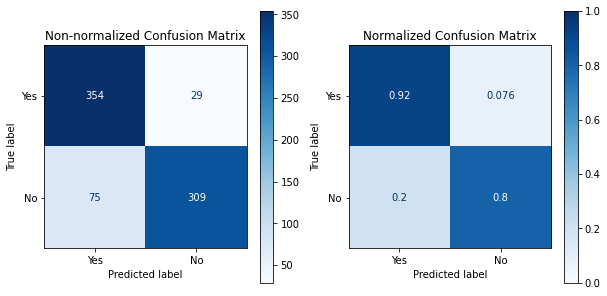

In [38]:
# Number of singular values (k) used that produces maximum prediction accuracy on validation data
# with relatively short amount of time
# k_singularval = (accuracy.index(max(accuracy[:30])) + 1) * 5
k_singularval = 45
varname = 'SVD - ' + str(k_singularval)
print("Classifying test data with k =", k_singularval, "singular values:")

# classifying test data
start = time.time()
test_y_pred = classify_test(test_x, k_singularval, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

# plotting results in confusion matrix
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result[varname] = {'Time' : svd_train_time + time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

## Logistic Regression

Before the start of training a model using logistic regression, my guess would be that its results would be similar to the linear kernel SVM, simply because of the following:

- Logistic regression is a linear classifier, meaning the training data will be separated by a single straight hyperplane. Its only difference with the linear kernel SVM model is the way the hyperplane is produce. Due to how well the linear kernel SVM performed, I am expecting the logistic regression to also produce similar results. With this in mind, I am also expecting the Logistic Regression to produce results that are significantly better than the sigmoid kernel SVM and the SVD classifiers..

C:\Users\LZFun\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Time taken: 236.27 seconds


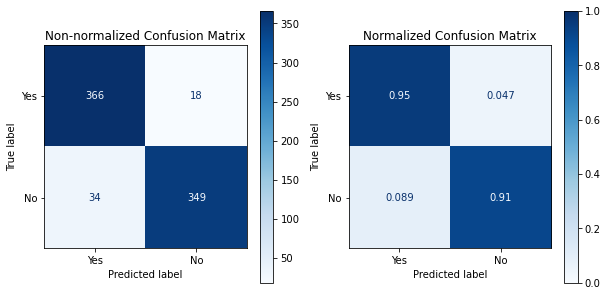

In [16]:
from sklearn.linear_model import LogisticRegression

start = time.time()
classifier = LogisticRegression(solver = 'saga', penalty = 'l1', C =100, max_iter = 100)
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Logistic Reg.'] = {'Time' : time_taken,
                                          'True Positive' : tp,
                                          'True Negative' : tn,
                                          'False Positive' : fp,
                                          'False Negative' : fn}

##### Notes:

The results from the classification via Logistic Regression was slightly better than expected, as compared to the SVM with linear kernel. However, we always get the warning that `the coef_ did not converge` regardless of how much the `max_iter` parameter was extended. This is probably due to the fact that the data set is not separated linearly and that some data points were not separable by Logistic Regression.

## Linear Discriminant Analysis (LDA)

Just like the Logistic Regression, LDA is also a linear classifier. Hence, it is also expected that this classifier will fare similarly to the linear kernel SVM and Logistic Regression.

Time taken: 117.23 seconds


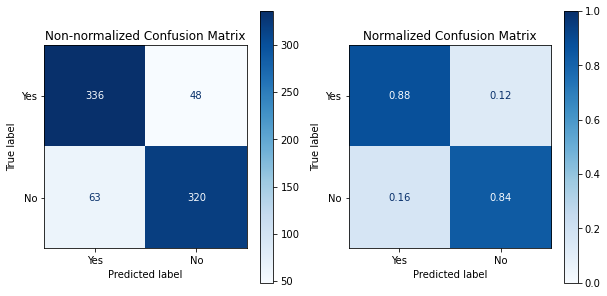

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
classifier = LinearDiscriminantAnalysis(solver = 'svd')
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['LDA'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

##### Notes:

While I have predicted that the LDA will fare similarly to the linear kernel SVM and Logistic Regression, it is very unexpected that the overall error rate of LDA is so much worse than both methods. 

The next section is my findings on why LDA has fared badly as compared to the linear kernel SVM and Logistic Regression.

### Logistic Regression vs LDA

After running the Logistic Regression and LDA classifiers, it is common to wonder why there is such a huge difference in accuracy between the two classifiers.

According to several websites (links under the Reference and Resources section), the difference in accuracy is mainly due to the different requirements required by both of these classifiers:

* In Logistic Regression, the distributions of the predictors do not matter. On the other hand, LDA assumes that the predictors follow a multivariate normal distribution.

* In Logistic Regression, there is no requirement in the predictors' within-group covariance matrices. This is hugely different compared to the LDA, where we assume that the sample predictors' (the training data's predictors in our case) within-group covariance matrices (namely $S_{Yes}$ and $S_{No}$) should be equal to the population predictors' covariance matrix (denoted $\Sigma$).

As we can see in our data, each "feature" or "predictor" actually represents the pixel values of each pixel, which means that they are very likely not normally distributed, nor do they have covariances equal to a "population" covariance. I believe that it is due to the restrictions of the LDA classifier and the failure of the predictor variables to meet the restrictions, LDA does not perform as well as the Logistic Regression in this case.

## Random Forest

The Random Forest Classification method is basically done by running Decision Tree Classification methods multiple times with slight tuning in data and features used. So before we dive straight into Random Forest Classification, let's first train our training data with a Decision Tree Classifier.

The general idea of running a Decision Tree Classifier is simple:

1. We have $m$ training data with $n$ features. In our case, this translates to our 3449 rows of training data and 65,536 features (pixels).

2. We start off at a root node with all our training data. Then, a feature is selected to split the training data into two. Eg. we start with the pixel (1,1) in each image. Images with pixel (1,1) values more than $\alpha$ will be transferred to a new node at the right side of the root node, and the rest will be transferred to a new node at the left side of the root node.

3. As of right now, we have transferred all of our training data into nodes that are either at the left or right nodes of the root node. Now, we want to check if any of the nodes contain only a single class, ie. the node contains images that are all of class 'Yes' or all of class 'No'. If this is the case, we are done with this node, no further action is needed to work on this node. Otherwise, we will need to repeat the process of step 2, this time selecting a different feature to classify our training data. Note that in every classification step, we are not allowed to transfer our data into a used node (ie. it has to be a new node every step).

4. After running steps 2 and 3 multiple times, we will arrive at a point where each and every non-empty nodes contain only a single class. At this point, we are done.

Note that the Decision Tree Classification method has the following problems:

* The time taken can be quite long depending on the data set, or the chosen training data. This is due to the fact that the "learning of optimal decision tree is NP-complete" (Wikipedia). This can be observed even when running the classification method on this data set, where the time taken to train the model and classify the testing data can go as fast as less than 2 minutes, to being as slow as more than 2 hours.

* Decision Trees tend to overfit. Recall that we will keep transferring data into new nodes until each node contains only one class of data. This becomes a problem when we put our test data into the decision tree since the properties of our test data is not exactly the same as those of the training data.

Time taken: 116.59 seconds


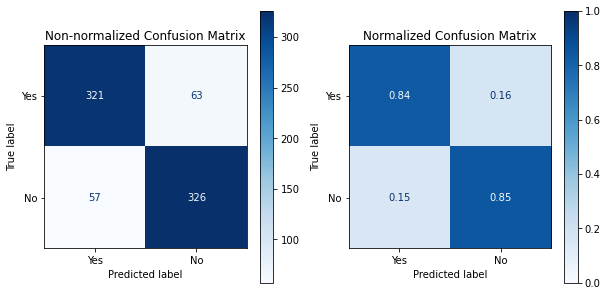

In [18]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
classifier = DecisionTreeClassifier(criterion = 'gini')
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Decision Tree'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

After running the Decision Tree Classifier above, we have the following findings:

* The time taken for this to run is actually quite short. The only other classifier with such short time taken so far is the classifier that utilizes SVD properties.

* The results of this test is also very accurate. This is due to the fact that this classifier does not apply to strictly linear data, unlike the linear kernel SVM, Logistic Regression, and LDA

Now that we have tried out the Decision Tree Classifier, we move on to the Random Forest Classifier. The Random Forest Classifier is different from the Decision Tree Classifer in the following ways:

* Instead of using all features to classify our training data, the features used is selected at random.

* Instead of using all of our training data for classification, the training data is selected at random with replacement (aka bootstrapping). This means that there is a chance that we might select the same exact data (although it is less likely if the size of data is huge).

Now, with our new randomly selected subset of training data with randomly selected features, we run the Decision Tree Classifier once again. 

This time, however, we will be running all the above for a number of times (note the parameter `n_estimators` in the code below) before concluding with a model that is an average of all the models we got.

Time taken: 29.32 seconds


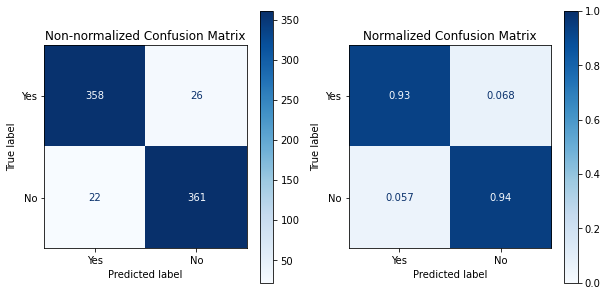

In [19]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
classifier.fit(train_x, train_y)
[[tp, fn], [fp, tn]] = plot_confmat(classifier, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

classification_result['Random Forest'] = {'Time' : time_taken,
                                'True Positive' : tp,
                                'True Negative' : tn,
                                'False Positive' : fp,
                                'False Negative' : fn}

##### Notes:

After running the Random Forest Classifier, the results that was obtained was very unexpected to me... in a good way. This classification method has given us one of the highest accuracy rates among all the methods we have used so far, and in the shortest amount of time too! 

A thing to note about the Random Forest Classifier is that, even after playing around with the `n_estimators` parameter with values 100, 200, 1000... The accuracy of the classifiers are highly similar, although the time taken to build the classifiers increases rapidly. Hence, I have decided to use `n_estimators = 100` since it gives us the best accuracy vs time trade-off.

## Neural Network

This section is significantly trickier than the others, due to the following reasons:

* more parameters to tune

* there is an infinite amount of different types of Neural Network architecture. Other than the neurons in the input and output layers being fixed, there is an infinite number of hidden layer and neuron count architectures. A lot of experimentation has to be done regarding the number of hidden layers and neurons to be used in our model.

Due to these reasons, the changes in code for each parameter tune will not be repeated here, and will instead be done in a separate files, namely `keras_nn.py` (for model 1) and `keras_cnn.py` (for model 2). These files are written by importing the Keras library since they are easy to navigate and make parameter changes.

Additionally, for future references, I have also written `tensorflow_nn.py` that do the same exact things as `keras_nn.py` but instead using the tensorflow library.

### Model 1: Feed-Forward Neural Network

This is the simplest kind of Neural Network. The inputs are taken as 49152 separate "variables" and each input is connected to every node in the first hidden layer. If there is more than one hidden layer, each node in each layer will be connected to every node in the next layer. Finally, the same thing will happen to the last hidden layer, which connects to every output nodes.

In the process of searching for the best possible Feed-Forward Neural Network, the following steps are taken:
1. Data Augmentation - This is done to increase the number of inputs since Neural Networks thrive under the large amounts of data.
2. Parameter Tunings - Some of the parameters tuned include:  
   * L1 and L2 regularization parameters
   * Learning rate and batch sizes  
   * Dropout regularization
3. Experiment with different Neural Network architectures.

### Data Augmentation

One of the issues I faced in training a good Neural Network model is the lack of data. The reasons are as follows:

1. In order for the classifiers to produce a better generalization in classifying the data, more training data has to be provided. This would mean that I will have to sacrifice the number of testing data. 

2. Similarly, the reverse is also true, that using more of the data as test data would mean sacrificing the number of training data. I would like to see how my classifiers fare in general, and having a small testing data set can lead to higher than normal accuracies.

3. I would like to use some validation data while training my model. This further reduces my training/testing data set.

In order to solve the above issues, I increased the number of training data by  
   
 * using the transformed version of the original images
 * horizontally flipping each of the transformed image (mirror images)  
 * flipping each of the transformed images (upside down images)  
 * horizontally flipping each of the upside down images (mirror of upside down images)  
 * rotating the transformed version of the original images to the right (right rotated images)
 * flipping each right rotated images (upside down of right rotated images)  
 * rotating the transformed version of the original images to the left (left rotated images)  
 * flipping each left rotated images (upside down of left roated images) 

This way, I now have 8 times the number of training data as compared to my original training data set. The code below is used to change the format of our data to fit a neural network model, and augment each training image to increase the training data. The full function is written in the module `data_augmentation.py`.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import data_augmentation

# changing format of data + splitting training data into train and validation sets
INPUT_NODES = train_x.shape[1]
OUTPUT_NODES = 2
       
# splitting training data into train and validation data sets
(nn_x_train, nn_x_validation, nn_y_train, nn_y_validation) = train_test_split(train_x, train_y, train_size = 0.8, test_size = 0.2, random_state = 1)

# increase number of training data
(nn_x_train, nn_y_train) = data_augmentation.increase_data(nn_x_train, nn_y_train, (128,128,3))

# convert test and training y values from 'Yes' or 'No' to [1,0] or [0,1] respectively
onehot_encoder = OneHotEncoder(sparse=False)
nn_y_train = nn_y_train.reshape(len(nn_y_train),1)
nn_y_train = onehot_encoder.fit_transform(nn_y_train)
nn_y_validation = nn_y_validation.reshape(len(nn_y_validation),1)
nn_y_validation = onehot_encoder.fit_transform(nn_y_validation)
test_y_01 = test_y_true.reshape(len(test_y_true),1)
test_y_01 = onehot_encoder.fit_transform(test_y_01)

### Default Settings and Values in Training of Neural Network

The following are some settings that are set as our default in the training of our Neural Network, and will not be changed unless stated specifically in the section.

1. Optimizer: Adam

2. Learning Rate: `1e-4`

3. Batch Size = 256

4. Network Architecture: 49152 $\rightarrow$ 500 $\rightarrow$ 2

### Effects of Parameter Tuning

In training the best possible Neural Netowrk model, there are certain parameters that needs to be tuned and experimented on. In the following sections, I have experimented the parameters in different ways and observed their effects on cost and accuracy changes in my training and validation data.

* #### Standardization (Transformation) of data and L1/L2 regularization parameters

 In this section, we want to observe how transforming the data and adding regularization parameters can affect the accuracies of the training, validation and test data.

 The type of data transformations used here are:

 1. No transformation, ie. the same input data from before is used

 2. Normalized input, ie. each input neuron value is transformed with the following formula:
$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$
where $x$ is the initial input value for a particular neuron, and $x_{min}$ and ${x_max}$ are smallest and largest input values for the particular neuron among the entire training data set.

 3. Standardized input, ie. each input neuron value is transformed to fit a normal distribution via the following formula:
$$x' = \frac{x - \mu_x}{\sigma_x}$$
where $x$ is the initial input value for a particular neuron, and $\mu_x$ and $\sigma_x$ are the mean and standard deviation respectively for the particular neuron among the entire training data set.

 As for our L1 and L2 regularization parameters, the reason we want to use them is this:  
 - We have our cost function which we want to minimize in order to improve our model. In general, the following are some of the types of cost functions:
 
   1. Quadratic cost:  
   $$C = \frac{1}{n} \sum_{i = 1}^{n}||y_i - y'_i||_2$$
      where $y_i$ is the actual value of the responding variable for data point $i$ and $y'_i$ is its corresponding predicted value. This is usually used when we train our Neural Network model for regression purposes and our output layer has only one node.
   
   2. Cross Entropy cost:  
   $$C = \frac{1}{n} \sum_{i = 1}^{n} \sum_{c = 1}^{k} y_{i,c} \log_e({y'_{i,c})}$$
      where $y_{i,c} = \begin{cases} 1 & \text{if data point } i \text{ is in class } c \\ 0 & \text{otherwise} \end{cases}$ and $y'_{i,c}$ is the predicted probability that the data point $i$ is class $c$. This is usually used when we train our Neural Network model for classification purposes and our output layer has $k$ number of nodes (to classify data points into $k$ classes). Note that in the case of binary classification (2 classes), one can use an output layer with only one node.
      
   In this analysis, we will be using the cross entropy cost function.
   
 - Now, simply having a cost function might not be enough as it leads to a possible overfitting of the data set. To counter this issue, we add regularization parameter(s) into our cost function. There are 3 (main) types of regularization that we will use in the training of this Neural Network:
 
   1. L1 Regularization
      $$L1 = \lambda_1 \sum_{j = 1}^{p} |\beta_j|$$
      where $\beta_j$ represents each weight and bias in the neural network model.
      
   2. L2 Regularization  
      $$L2 = \lambda_2 \sum_{j = 1}^{p} \beta_j^2$$
   
   3. Dropout  
      In Neural Network, using a dropout regularization basically means randomly reducing the number of nodes (in the hidden layer) and arcs as we train the model in order for update the model's weights and parameteres less which can better generalize the data set. This method will not be experimented here.
      
 - With this in mind, we can now add either the L1 or L2 (or both) regularization into our cost function. Our new cost function becomes $$C' = C + L1 + L2$$
   
   We can now experiment around with different $\lambda_1$ and $\lambda_2$ values to see which values produce the best model. Note that setting a $\lambda$ too large can lead to underfitting, whereas setting it too small can lead to overfitting.
 
 For our L1 and L2 regularization parameters, we tested each of them with the values `0`, `1e-4`, and `1e-2`, ie:
 
 1. L1 = `0`, L2 = `0`
 2. L1 = `0`, L2 = `1e-4`
 3. L1 = `0`, L2 = `1e-2`
 4. L1 = `1e-4`, L2 = `0`
 5. L1 = `1e-4`, L2 = `1e-4`
 6. L1 = `1e-4`, L2 = `1e-2`
 7. L1 = `1e-2`, L2 = `0`
 8. L1 = `1e-2`, L2 = `1e-4`
 9. L1 = `1e-2`, L2 = `1e-2`
 
 The code and results are shown below.

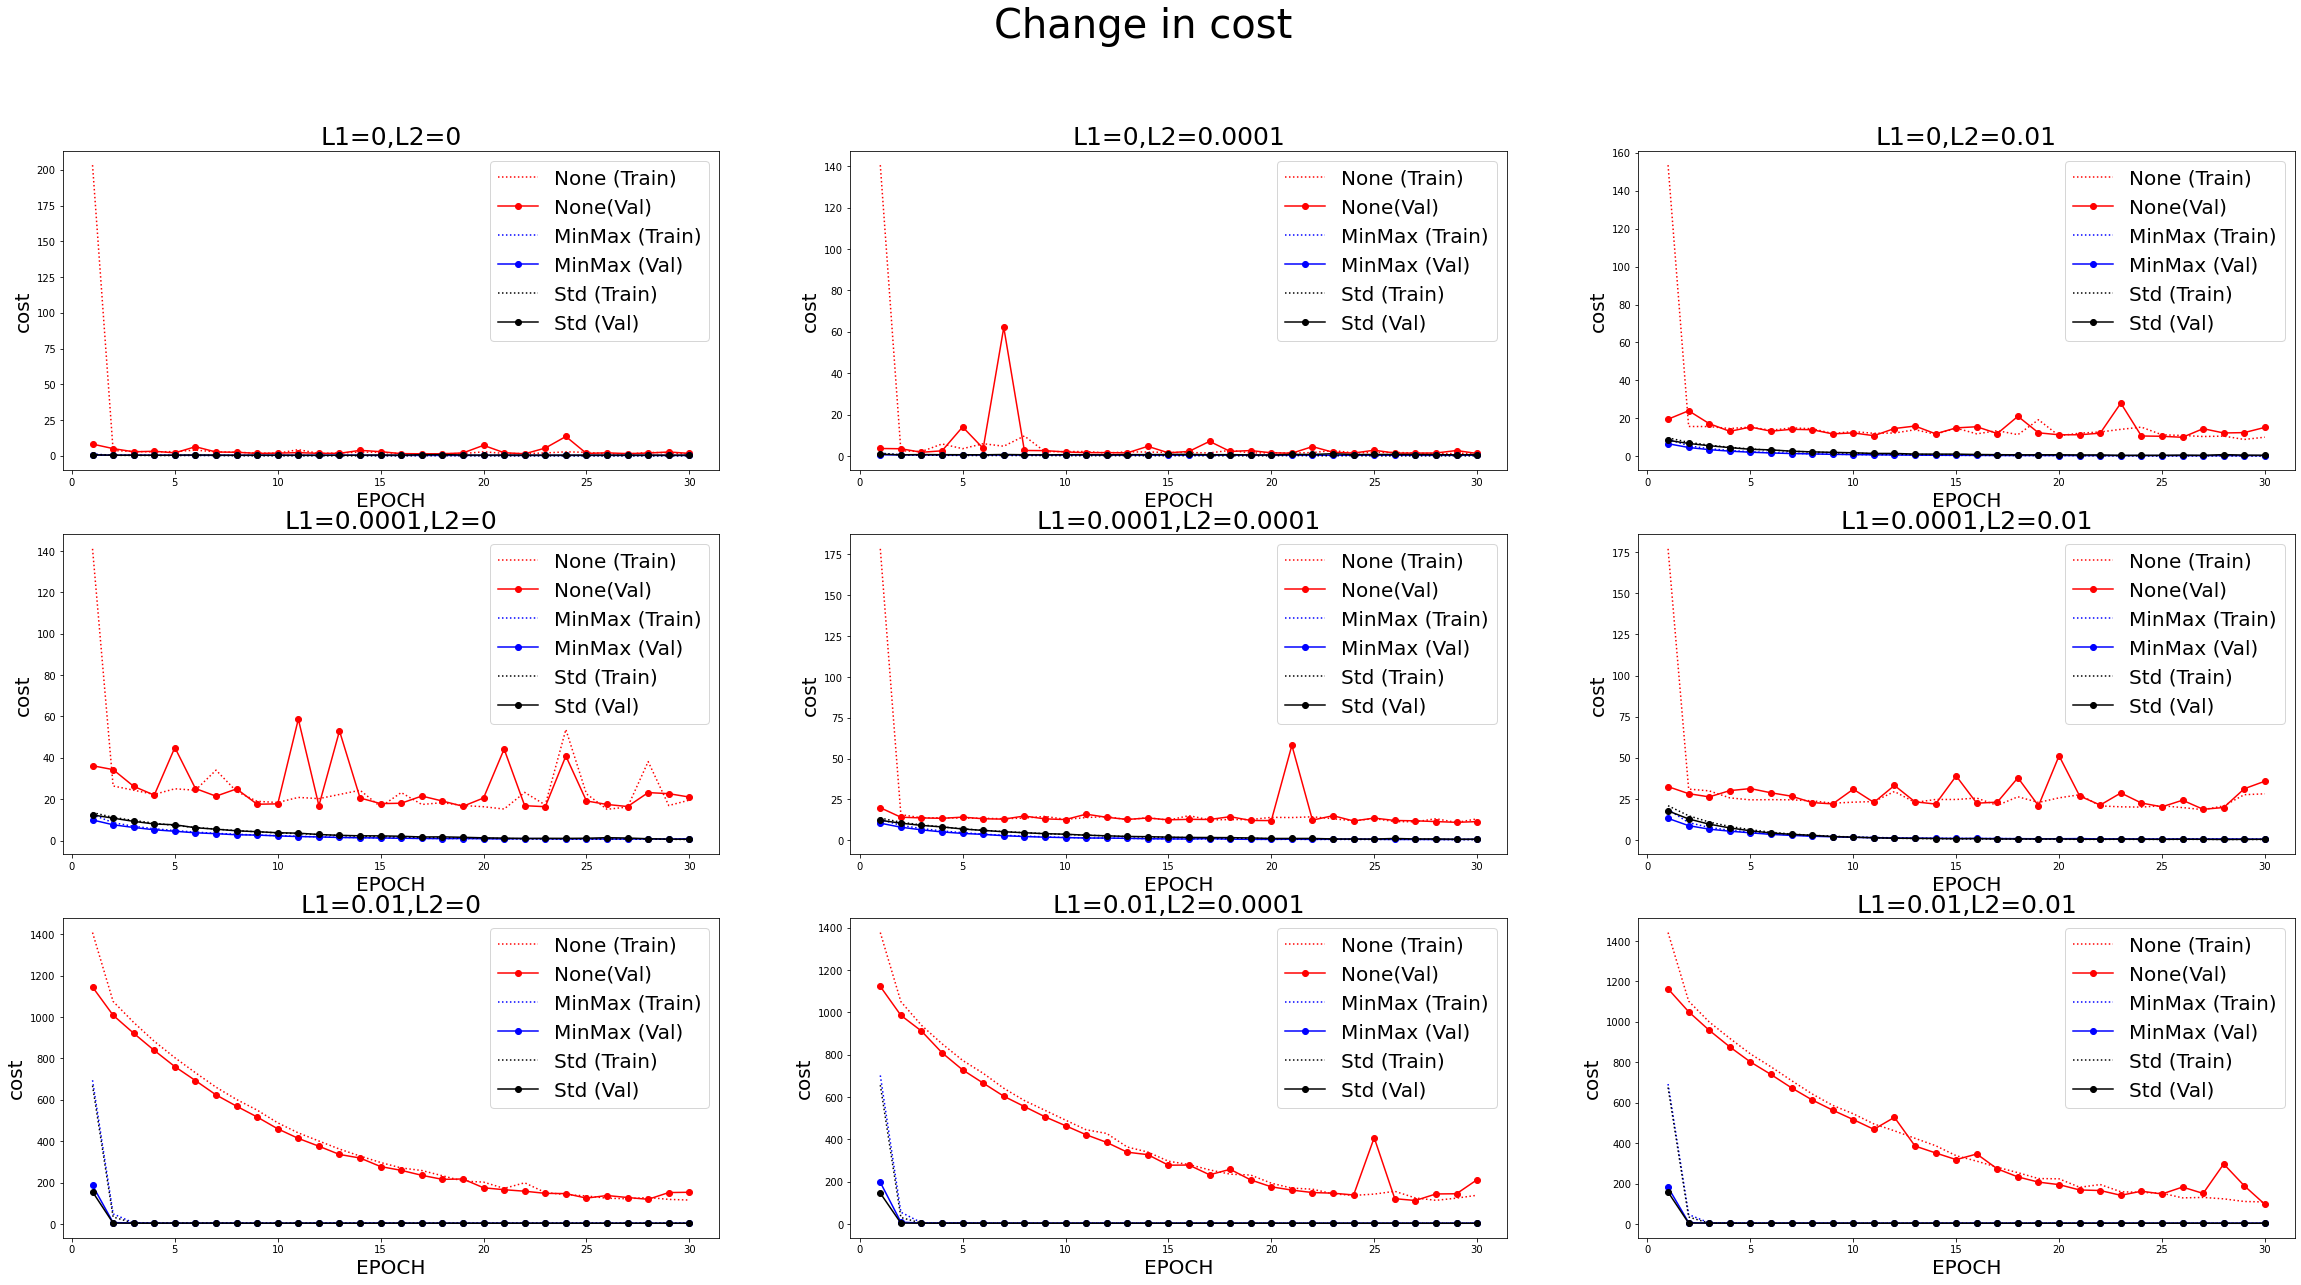

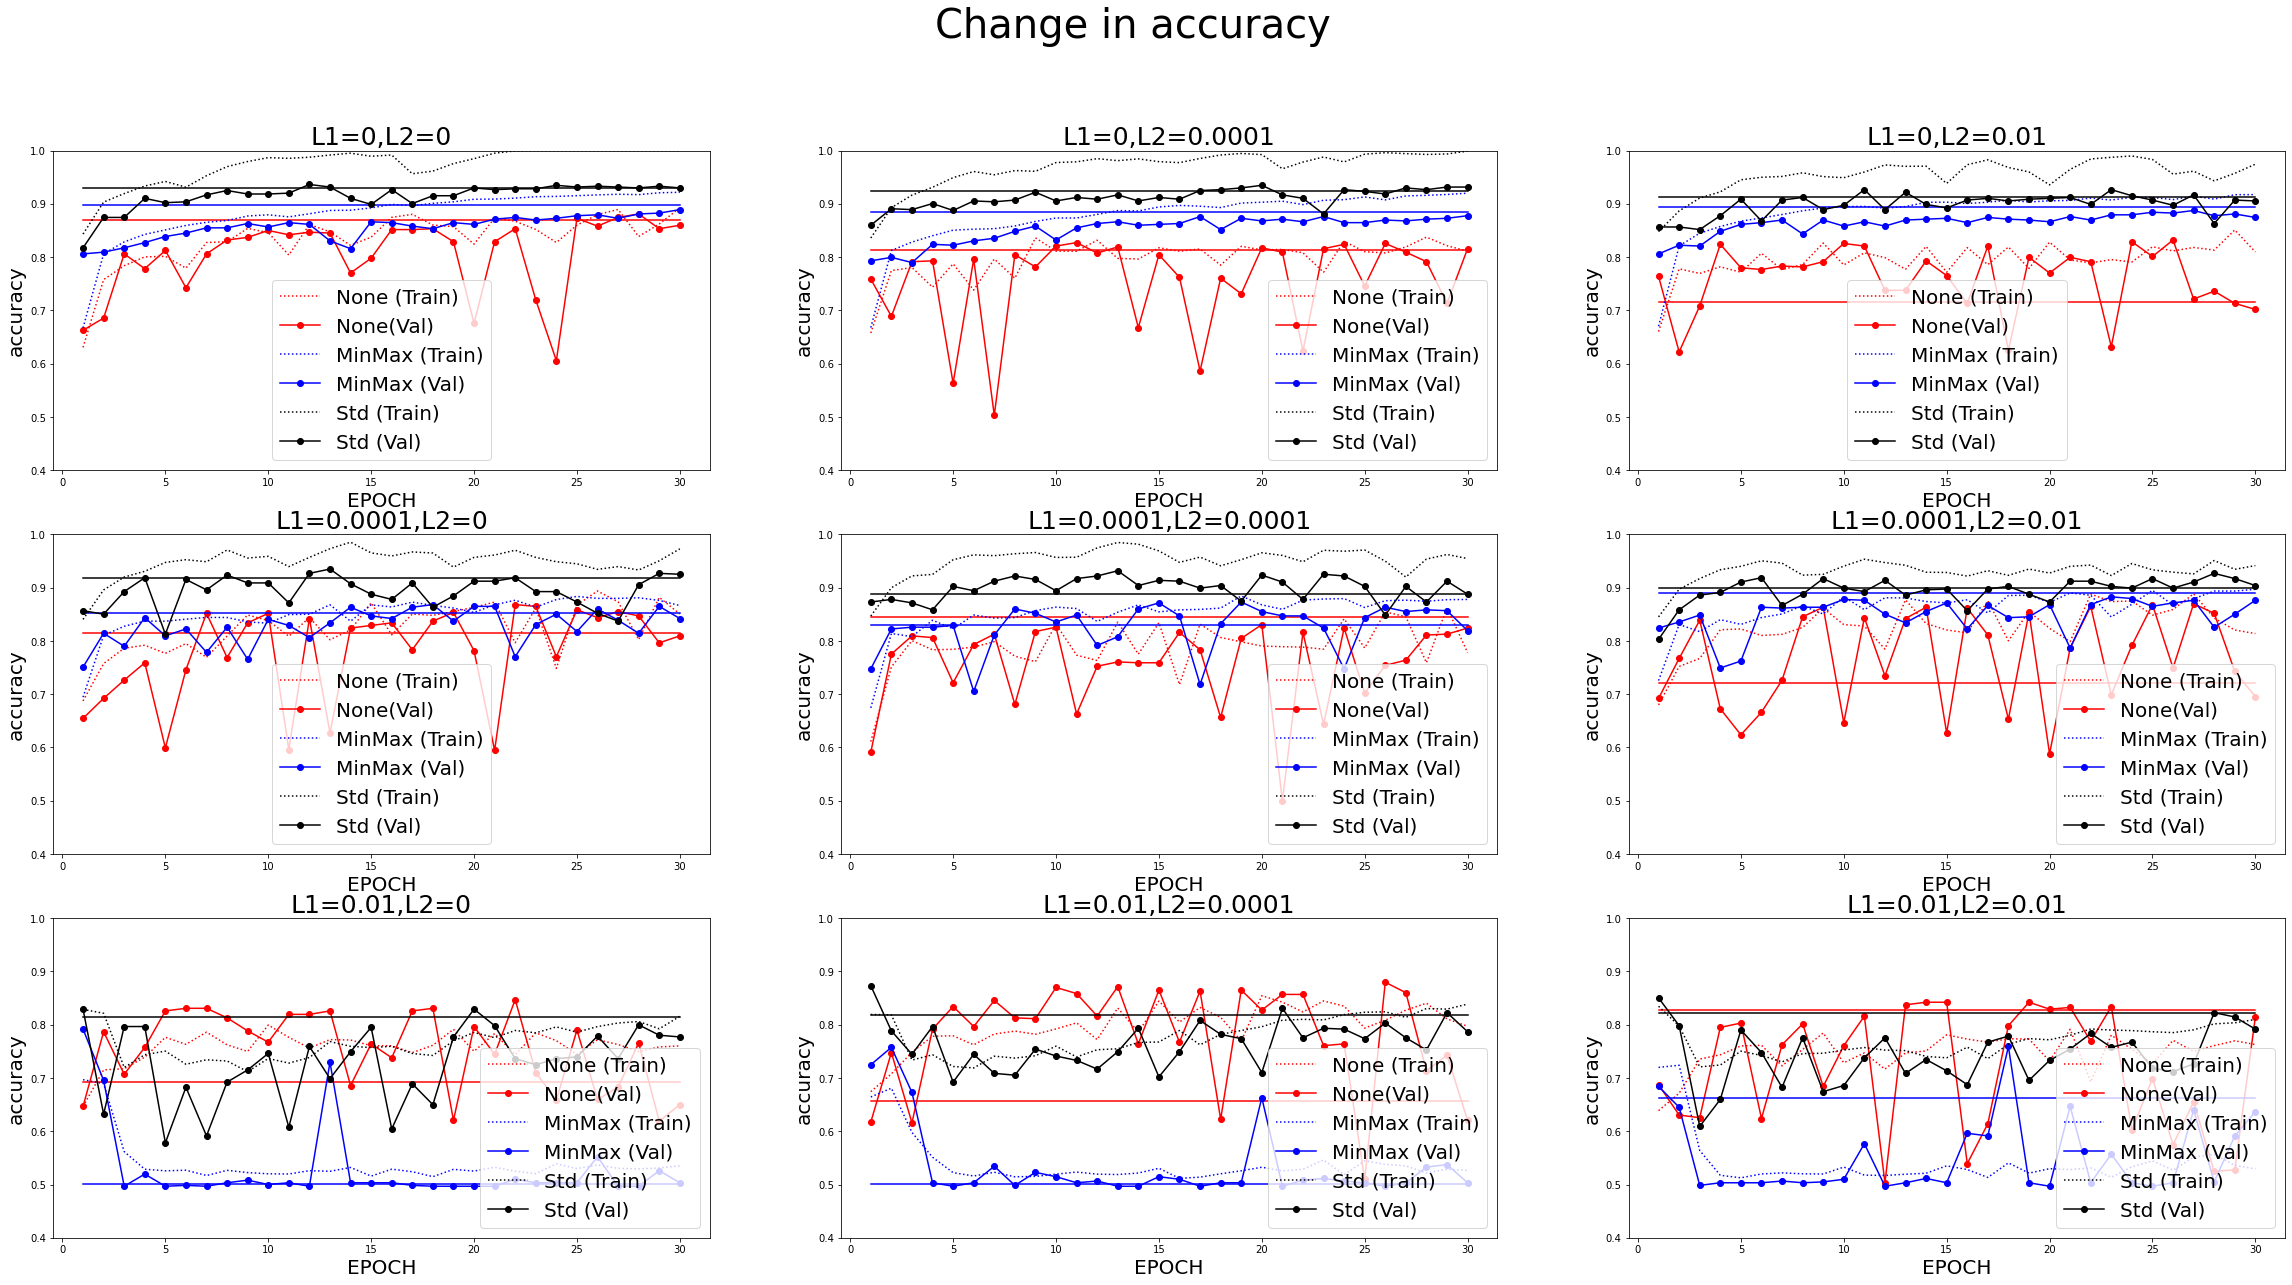

In [6]:
# Neural Network architecture (neurons in hidden layer)
LAYER1_NODES = 500

# Setting epochs, batch size and learning rate
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 1e-4

# L1 and L2 ragularization parameters to experiment with
L1_list = [0, 1e-4, 1e-2]
L2_list = [0, 1e-4, 1e-2]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras import regularizers #for l1 or l2 regularizers
from keras.callbacks import EarlyStopping #stop training when monitored argument stops decreasing/increasing
import matplotlib.pyplot as plt

# prepare dataset with input and output scalers, can be none
def transform_dataset(input_scaler, train_X, val_X, test_X):
    # scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(train_X)
        # transform training dataset
        trainX = input_scaler.transform(train_X)
        # transform validation dataset
        validX = input_scaler.transform(val_X)
        # transform test dataset
        testX = input_scaler.transform(test_X)
        return trainX, validX, testX
    else:
        return train_X, val_X, test_X

# train the Neural Network model    
def evaluate_model(train_X, train_y, val_X, val_y, test_X, test_y):
    # define model
    model = Sequential([
        #input to first hidden layer
        Dense(units = LAYER1_NODES, input_dim = INPUT_NODES,
              activation = 'relu', kernel_constraint= maxnorm(4),
              kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)),
                       
        #second hidden layer to output
        Dense(units = OUTPUT_NODES, input_dim = LAYER1_NODES, activation = 'softmax')
        ])
    
    # compile model
    opt = optimizers.adam(learning_rate = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    # fit model
    history = model.fit(train_X, train_y, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data = (val_X, val_y), verbose = 0) 

    # evaluate the model
    _, test_acc = model.evaluate(test_X, test_y, verbose = 0)
    
    train_cost = history.history['loss']
    train_acc = history.history['accuracy']
    val_cost = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    return (train_cost, train_acc, val_cost, val_acc, test_acc)

# transform data and train model
def run_model(input_scaler, train_X, train_y, val_X, val_y, test_X, test_y):
    # get dataset
    trainX, valX, testX = transform_dataset(input_scaler, train_X, val_X, test_X)
    result = evaluate_model(trainX, train_y, valX, val_y, testX, test_y)
    return result

fig1, ax1 = plt.subplots(3,3, figsize = (40,20))
fig2, ax2 = plt.subplots(3,3, figsize = (40,20))
fig1.suptitle("Change in cost", fontsize = 40)
fig2.suptitle("Change in accuracy", fontsize = 40)
    
for i, L1 in enumerate(L1_list):
    for j, L2 in enumerate(L2_list):
        (none_train_cost, none_train_acc, none_val_cost, none_val_acc, none_test_acc) = run_model(None, nn_x_train, nn_y_train, nn_x_validation, nn_y_validation, test_x, test_y_01)
        (minmax_train_cost, minmax_train_acc, minmax_val_cost, minmax_val_acc, minmax_test_acc) = run_model(MinMaxScaler(), nn_x_train, nn_y_train, nn_x_validation, nn_y_validation, test_x, test_y_01)
        (std_train_cost, std_train_acc, std_val_cost, std_val_acc, std_test_acc) = run_model(StandardScaler(), nn_x_train, nn_y_train, nn_x_validation, nn_y_validation, test_x, test_y_01)
        
        ep = list(range(1,EPOCHS+1))
     
        # plot cost functions
        ax1[i,j].plot(ep, none_train_cost, 'r:', label = 'None (Train)')
        ax1[i,j].plot(ep, none_val_cost, 'ro-', label = 'None(Val)')
        ax1[i,j].plot(ep, minmax_train_cost, 'b:', label = 'MinMax (Train)')
        ax1[i,j].plot(ep, minmax_val_cost, 'bo-', label = 'MinMax (Val)')
        ax1[i,j].plot(ep, std_train_cost, 'k:', label = 'Std (Train)')
        ax1[i,j].plot(ep, std_val_cost, 'ko-', label = 'Std (Val)')
        ax1[i,j].set_xlabel('EPOCH', fontsize = 20)
        ax1[i,j].set_ylabel('cost', fontsize = 20)
        ax1[i,j].set_title('L1='+str(L1)+',L2='+str(L2), fontsize = 25)
        ax1[i,j].legend(fontsize = 20)
        
        # plot accuracy functions
        ax2[i,j].plot(ep, none_train_acc, 'r:', label = 'None (Train)')
        ax2[i,j].plot(ep, none_val_acc, 'ro-', label = 'None(Val)')
        ax2[i,j].plot(ep, [none_test_acc]*len(ep), 'r-')
        ax2[i,j].plot(ep, minmax_train_acc, 'b:', label = 'MinMax (Train)')
        ax2[i,j].plot(ep, minmax_val_acc, 'bo-', label = 'MinMax (Val)')
        ax2[i,j].plot(ep, [minmax_test_acc]*len(ep), 'b-')
        ax2[i,j].plot(ep, std_train_acc, 'k:', label = 'Std (Train)')
        ax2[i,j].plot(ep, std_val_acc, 'ko-', label = 'Std (Val)')
        ax2[i,j].plot(ep, [std_test_acc]*len(ep), 'k-')
        ax2[i,j].set_xlabel('EPOCH', fontsize = 20)
        ax2[i,j].set_ylabel('accuracy', fontsize = 20)
        ax2[i,j].set_ylim(0.4, 1)
        ax2[i,j].set_title('L1='+str(L1)+',L2='+str(L2), fontsize = 25)
        ax2[i,j].legend(fontsize = 20)

 ##### Notes:
 
 1. $\lambda_1$ for the L1 regularization seems to have negative effects on the training of the model, especially when we set it with large values such as 0.01. In such cases, regardless of the value of $\lambda_2$, our resulting models perform very badly. In short, the L1 regularization have resulted in the models underfitting.
 
 2. Discounting the cases where $\lambda_1 = 0.01$, we find that training inputs that are standardized perform best in regards to training a model that produces high training, validation and test accuracies. The models with standardized inputs can often produce training and test accuracies that are 5-10\% higher than that of the non-transformed original inputs, which produce the worst set of results among all 3 types of models.

 3. Similarly, in cases where we have the value of $\lambda_2$ set too large, we tend to observe a decrease in learning in the Neural Network models. In these cases, while the cost values constantly decreases, there tends to be no change/fluctuations around the a less than optimum accuracies in the training and validation data. The fix to this problem is to decrease the value of $\lambda_2$. However, this case of underfitting is not as severe as that of the L1 regularization.

 4. The best results is obtained when we use only the L2 regularizer and set $\lambda_2$ = `1e-4`. There seems to be a lot more fluctuations and lower accuracy values if we have $\lambda$ go any smaller, although things might change if we also switch out certain other parameters.

 5. Regardless of L1 and L2 values used, we find that the models utilizing the original data (not transformed) tend to have significantly higher costs as compared to the normalized and standardized input data.


 * #### Batch size and Learning Rate
 
   1. In the paper "Don't Decay the Learning Rate, Increase the Batch Size" by Smith, Kindermans, Ying and Le, they wrote:  

    *** 
 "When we decay the learning rate, the noise scale falls, enabling us to converge to the minimum of the cost function. However we can achieve the same reduction in noise scale at constant learning rate by increasing the batch size. The main contribution of this work is to show that it is possible to make efficient use of vast training batches, if one increases the batch size during training at constant learning rate until $B \sim N/10$ (batch size around 1/10 of training data size). After this point, we revert to the use of decaying learning rates." 
    ***   
  Therefore, I had to play around with various different batch sizes and learning rates in this section to observe how the model fares with different combinations.
  
   2. The batch sizes that will be tested are 32, 256, and 1024. The learning rates that will be tested are 0.01, 0.0001, and `1e-6`.

  The code and results are shown below.

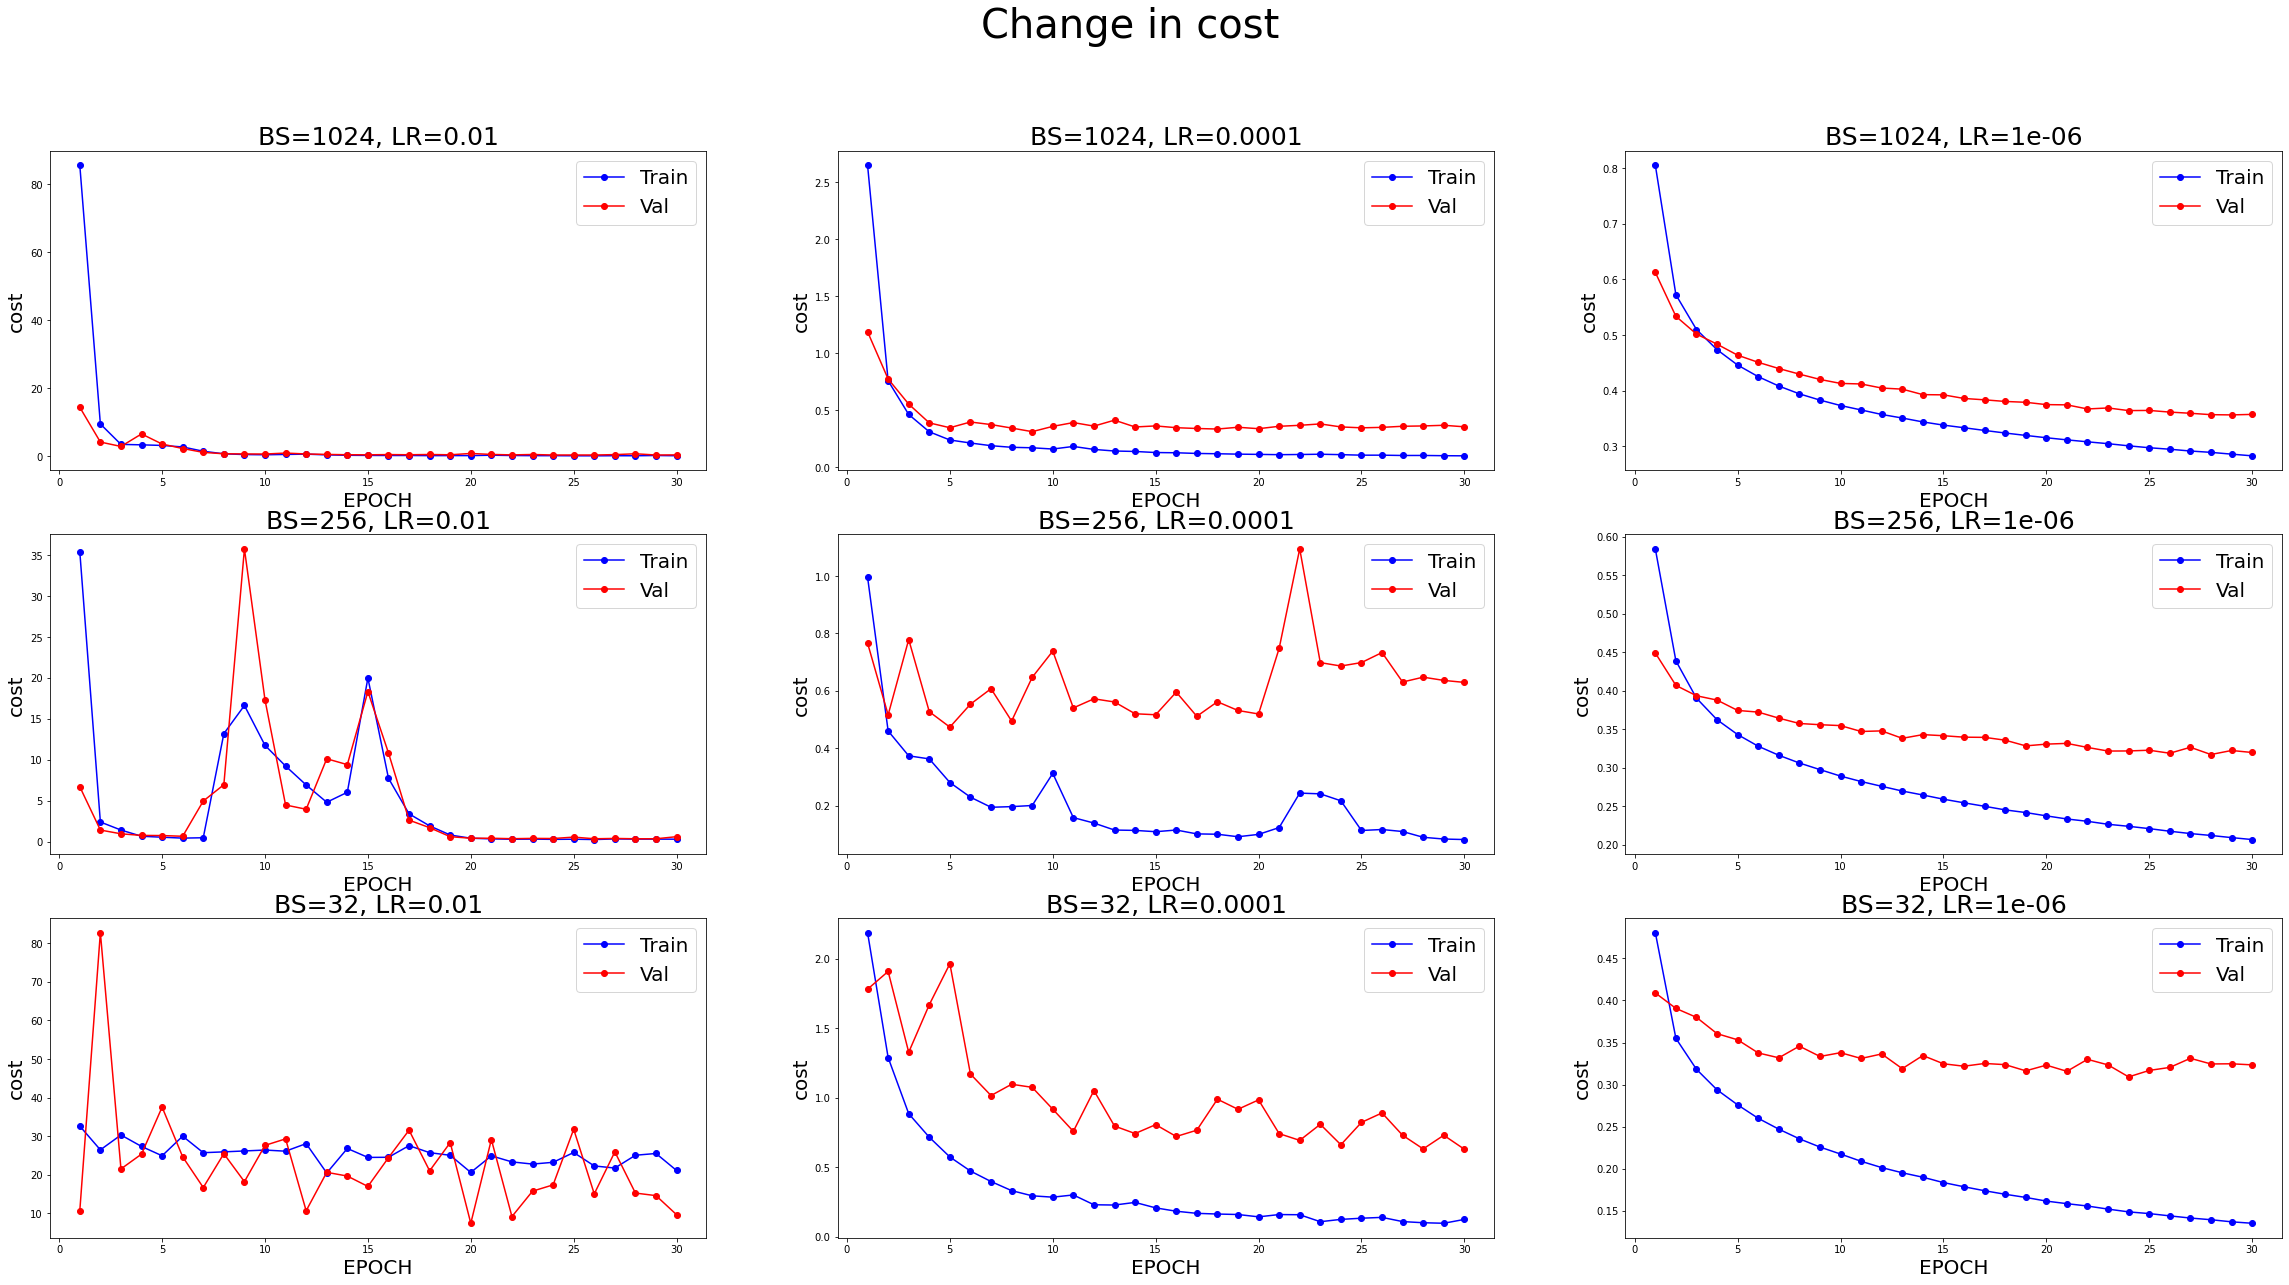

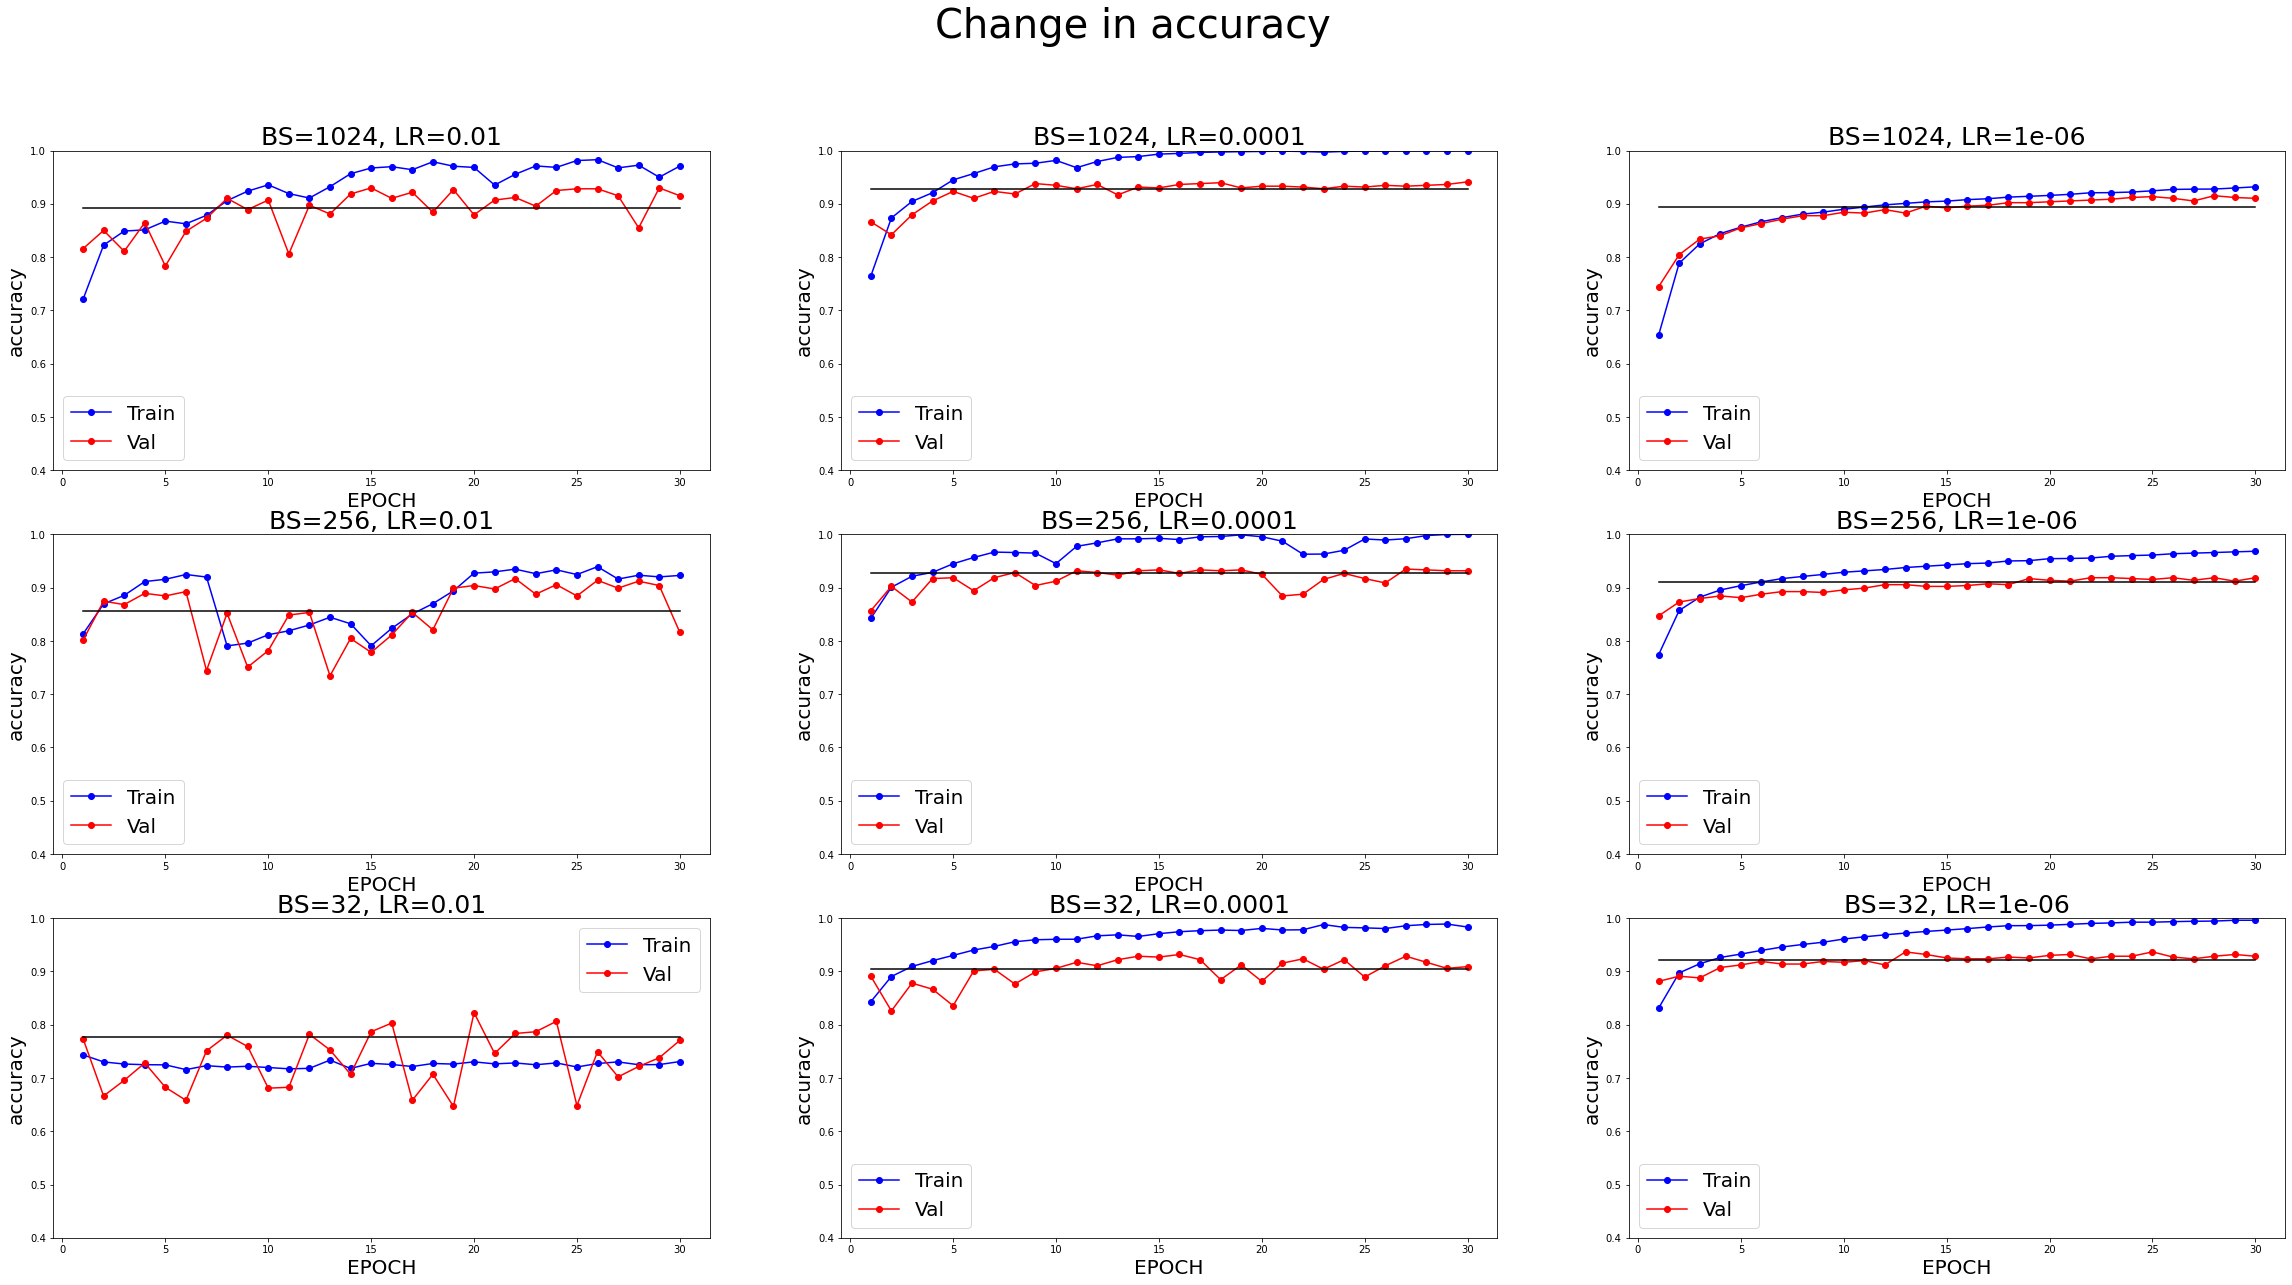

In [9]:
# Setting epochs and L1, L2 regularization parameters
EPOCHS = 30
L1 = 0
L2 = 1e-4


batch_size_list = [1024, 256, 32]
lr_list = [1e-2, 1e-4, 1e-6]

fig1, ax1 = plt.subplots(3,3, figsize = (40,20))
fig2, ax2 = plt.subplots(3,3, figsize = (40,20))
fig1.suptitle("Change in cost", fontsize = 40)
fig2.suptitle("Change in accuracy", fontsize = 40)
    
for i, BATCH_SIZE in enumerate(batch_size_list):
    for j, LEARNING_RATE in enumerate(lr_list):
        (train_cost, train_acc, val_cost, val_acc, test_acc) = run_model(StandardScaler(), nn_x_train, nn_y_train, nn_x_validation, nn_y_validation, test_x, test_y_01)
        
        ep = list(range(1,EPOCHS+1))
     
        # plot cost functions
        ax1[i,j].plot(ep, train_cost, 'bo-', label = 'Train')
        ax1[i,j].plot(ep, val_cost, 'ro-', label = 'Val')
        ax1[i,j].set_xlabel('EPOCH', fontsize = 20)
        ax1[i,j].set_ylabel('cost', fontsize = 20)
        ax1[i,j].set_title('BS='+str(BATCH_SIZE)+', LR='+str(LEARNING_RATE), fontsize = 25)
        ax1[i,j].legend(fontsize = 20)
        
        # plot accuracy functions
        ax2[i,j].plot(ep, train_acc, 'bo-', label = 'Train')
        ax2[i,j].plot(ep, val_acc, 'ro-', label = 'Val')
        ax2[i,j].plot(ep, [test_acc]*len(ep), 'k-')
        ax2[i,j].set_xlabel('EPOCH', fontsize = 20)
        ax2[i,j].set_ylabel('accuracy', fontsize = 20)
        ax2[i,j].set_ylim(0.4, 1)
        ax2[i,j].set_title('BS='+str(BATCH_SIZE)+', LR='+str(LEARNING_RATE), fontsize = 25)
        ax2[i,j].legend(fontsize = 20)

##### Notes:

1. Analysis on small batches as compared to large batches:  
 * Takes a long time to train, since the model has to be updated more times. In particular, the model updates every time we run through a batch. So if we have a training size $N$ and batch size $k$, the model is updated $N/k$ times per epoch.  
 * The smaller the batch size, the smaller the learning rate that should be used. With a small batch size, it is easier to overshoot in the gradient descent compared to bigger batch sizes. This causes the fluctuations that can be seen on some of the plots above where the learning rates are set to be `1e-6`.
 
2. Overall, it seems that using a batch size and learning rate pairing of (1024, 0.0001), (256, 0.0001) and (256, `1e-6`) produces the most balanced result in terms of no underfitting/overfitting and highest training/validation/test accuracies.

3. However, moving forward, we will be setting our batch size and learning rate pairing to be (1024, 0.0001) because:  
 - it leads to faster training of the model. This is due to the number of times the model weights/parameters are updated via backpropogation. Since the model is updated after going through each batch size, this means that a model that trains with a smaller batch size requires more updates, which is very time consuming. The converse is also true.  
 - using a large batch size leads to a smoother "curve" since the model generalizes better after each training. This is different when comparing with smaller batch sizes as the model updates and generalizes each time based on that smaller sample of input, meaning that the learning of the model is more focused on each particular batch size of training data than a generalization of all training data.

 * #### Network Architecture
 
   1. From what we have achieved so far, we seem to be able to train relatively good models. In fact, we have even managed to train some models to the point where we achieve 100\% training accuracies. However, the corresponding validation accuracies have never broken the 95\% mark, signalling the issue of overfitting.
   
   2. Other than incorporating regularization and changing the batch size and learning rate, another thing that could be done to improve the validation accuracy and reduce the overfitting of the model is to change the network architecture.
   
   3. The network architectures that we will experiment with are:
     * 49152 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 50 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 500 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 1000 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 50 $\rightarrow$ 50 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 50 $\rightarrow$ 1000 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 500 $\rightarrow$ 50 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 500 $\rightarrow$ 500 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 500 $\rightarrow$ 1000 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 1000 $\rightarrow$ 50 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 1000 $\rightarrow$ 500 $\rightarrow$ 2  
     * 49152 $\rightarrow$ 1000 $\rightarrow$ 1000 $\rightarrow$ 2  
     
   The code and results are shown below.

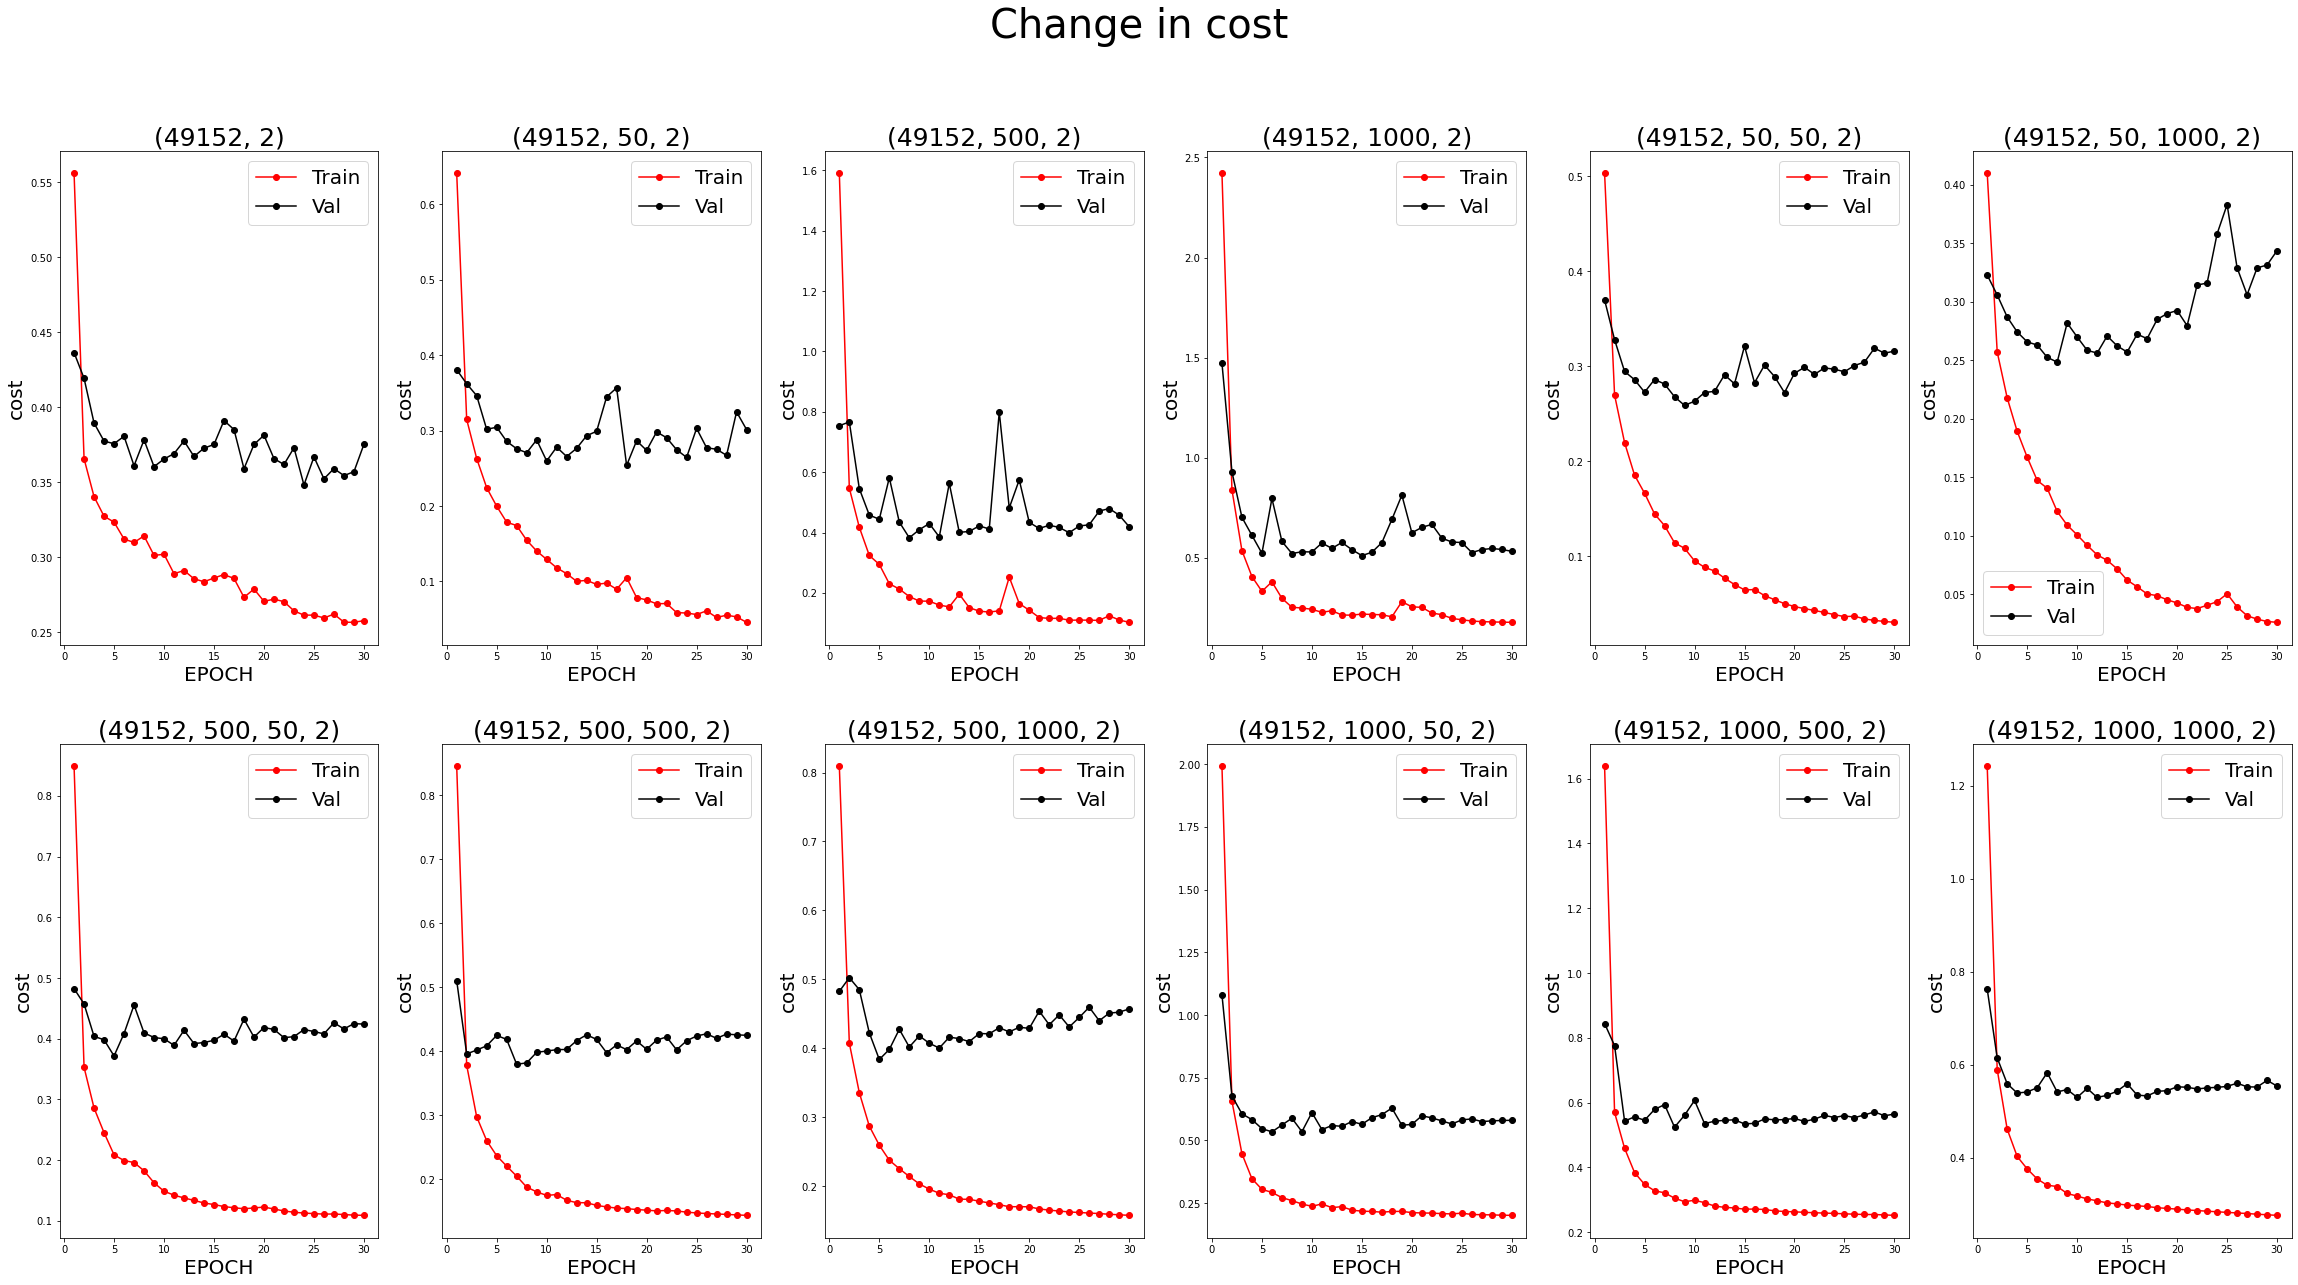

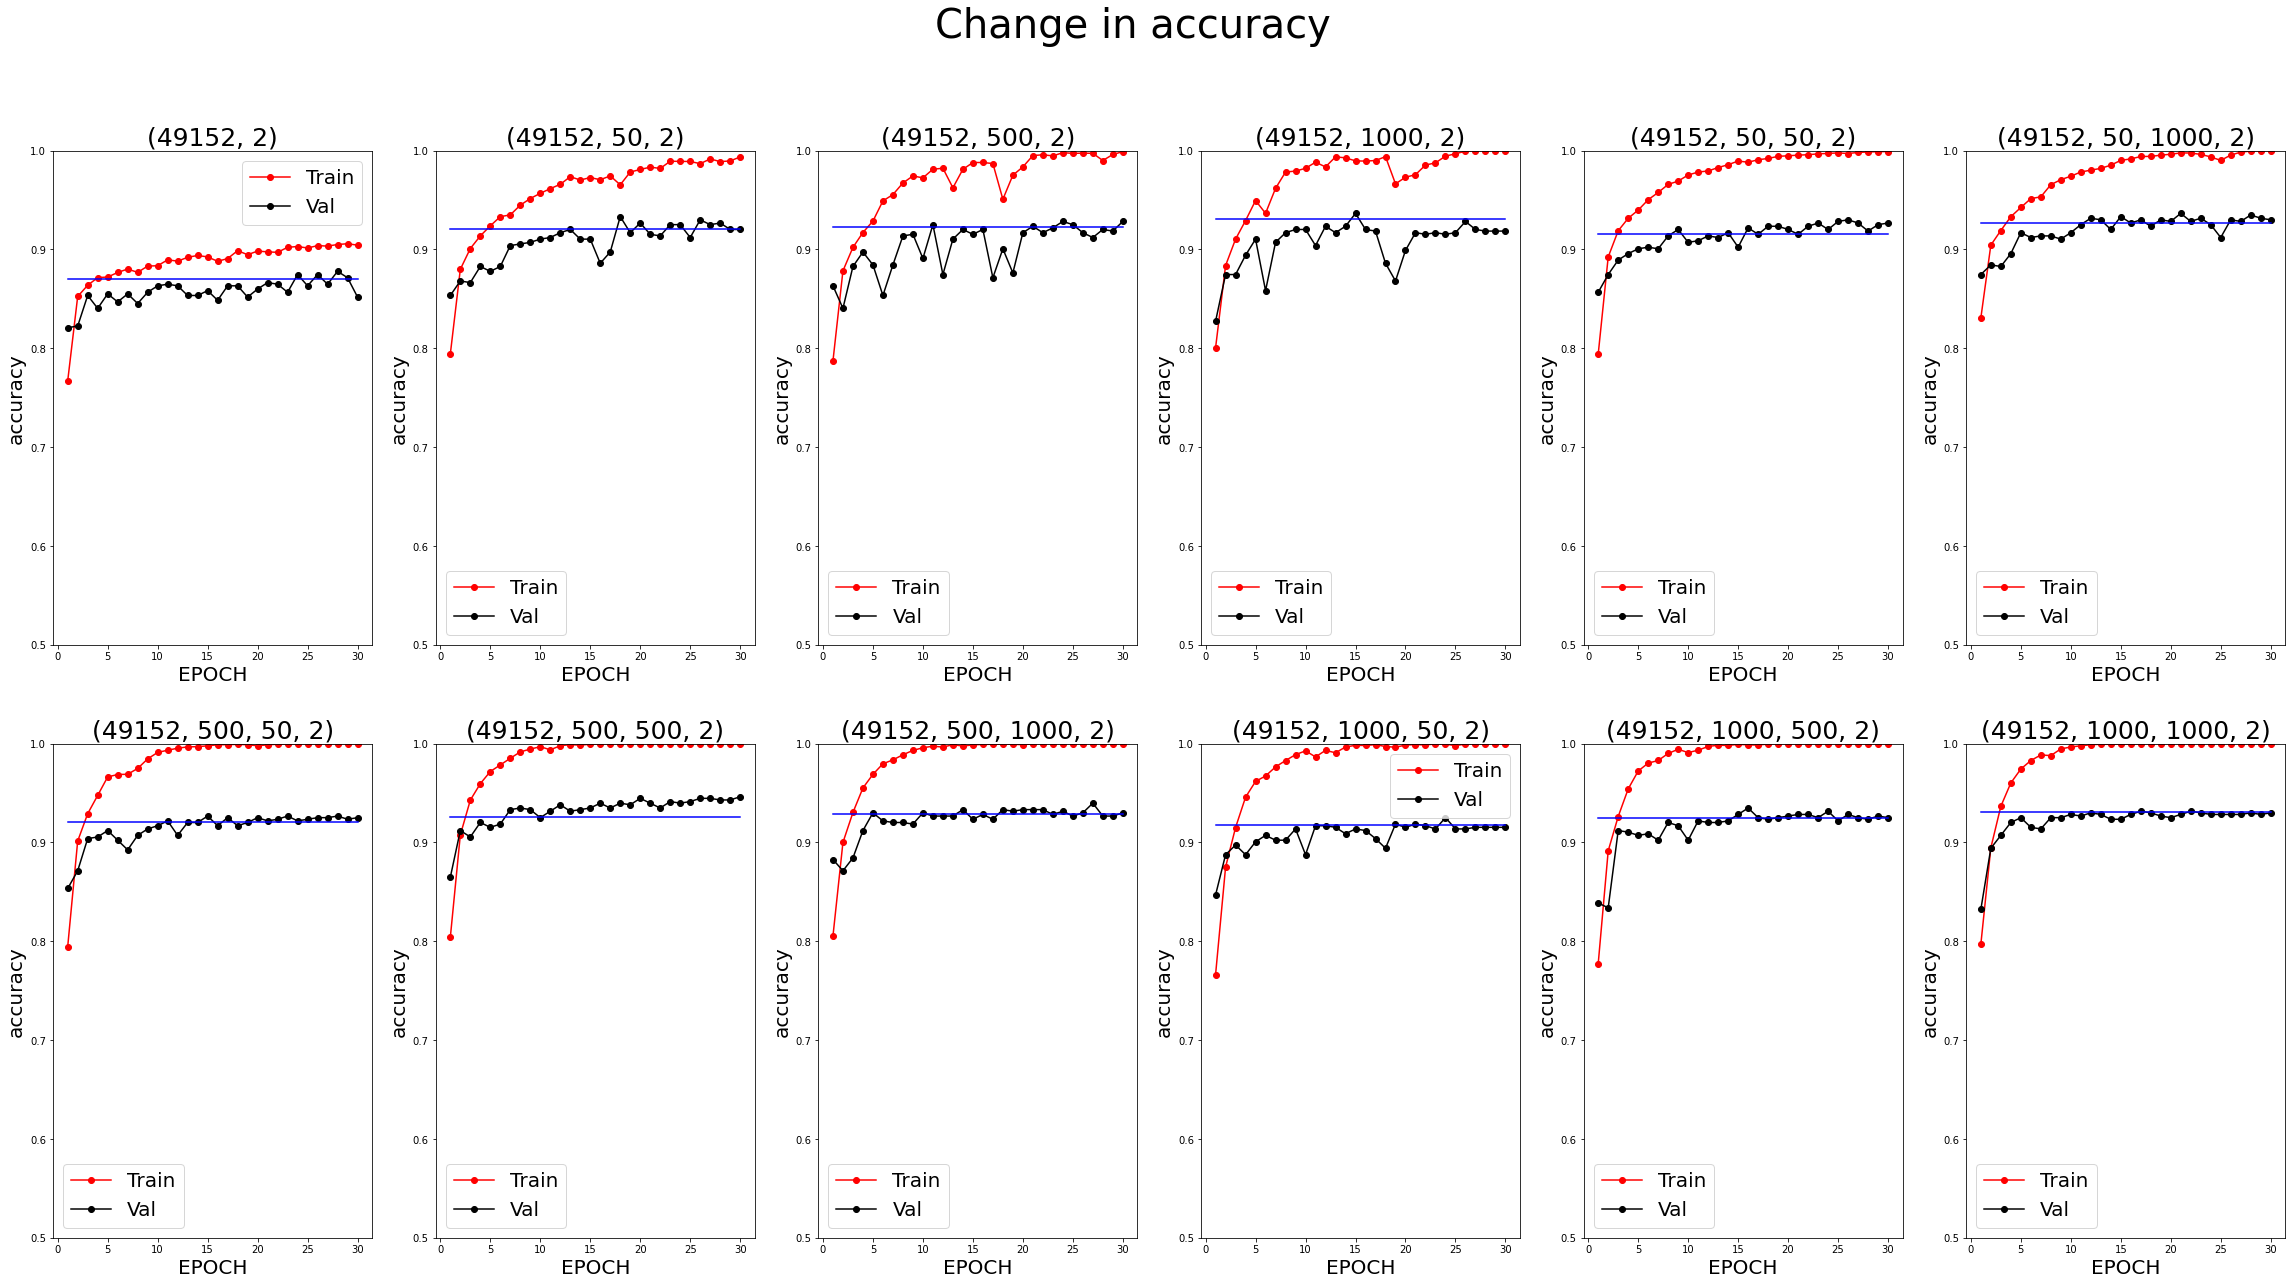

In [11]:
# Setting epochs, batch size, learning rate and L1, L2 regularization parameters
EPOCHS = 30
L1 = 0
L2 = 1e-4
BATCH_SIZE = 1024
LEARNING_RATE = 1e-4

NN_DESIGNS = [(INPUT_NODES, OUTPUT_NODES), # no hidden layer
              (INPUT_NODES, 50, OUTPUT_NODES), # 1 hidden layer
              (INPUT_NODES, 500, OUTPUT_NODES),
              (INPUT_NODES, 1000, OUTPUT_NODES),
              (INPUT_NODES, 50, 50, OUTPUT_NODES), # 2 hidden layers
              (INPUT_NODES, 50, 1000, OUTPUT_NODES),
              (INPUT_NODES, 500, 50, OUTPUT_NODES),
              (INPUT_NODES, 500, 500, OUTPUT_NODES),
              (INPUT_NODES, 500, 1000, OUTPUT_NODES),
              (INPUT_NODES, 1000, 50, OUTPUT_NODES),
              (INPUT_NODES, 1000, 500, OUTPUT_NODES),
              (INPUT_NODES, 1000, 1000, OUTPUT_NODES)]

def evaluate_model(nn_design, train_X, train_y, val_X, val_y, test_X, test_y):
    # define model
    model = Sequential()
    
    layers = len(nn_design)
    
    for i in range(1, layers):
        # for all layers, activation function is ReLU
        if i < layers-1:
            act = 'relu'
        # for final layer, activation function is softmax
        else:
            act = 'softmax'
            
        # adding the layers of NN
        model.add(Dense(units = nn_design[i], 
                    input_dim = nn_design[i-1],
                    activation = act,
                    kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
    
    # compile model
    opt = optimizers.adam(learning_rate = LEARNING_RATE)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

    # fit model
    history = model.fit(train_X, train_y, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data = (val_X, val_y), verbose = 0) 

    # evaluate the model
    _, test_acc = model.evaluate(test_X, test_y, verbose = 0)
    
    train_cost = history.history['loss']
    train_acc = history.history['accuracy']
    val_cost = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    return (train_cost, train_acc, val_cost, val_acc, test_acc)

(trainX, valX, testX) = transform_dataset(StandardScaler(), nn_x_train, nn_x_validation, test_x)

fig1, ax1 = plt.subplots(2,6, figsize = (40,20))
fig2, ax2 = plt.subplots(2,6, figsize = (40,20))

fig1.suptitle("Change in cost", fontsize = 40)
fig2.suptitle("Change in accuracy", fontsize = 40)
for i, design in enumerate(NN_DESIGNS):
    (train_cost, train_acc, val_cost, val_acc, test_acc) = evaluate_model(design, trainX, nn_y_train, valX, nn_y_validation, testX, test_y_01)
    
    ep = list(range(1,EPOCHS+1))
     
    ax1[i//6, i%6].plot(ep, train_cost, 'ro-', label = 'Train')
    ax1[i//6, i%6].plot(ep, val_cost, 'ko-', label = 'Val')
    ax1[i//6, i%6].set_xlabel('EPOCH', fontsize = 20)
    ax1[i//6, i%6].set_ylabel('cost', fontsize = 20)
    ax1[i//6, i%6].set_title(str(design), fontsize = 25)
    ax1[i//6, i%6].legend(fontsize = 20)
    
    ax2[i//6, i%6].plot(ep, train_acc, 'ro-', label = 'Train')
    ax2[i//6, i%6].plot(ep, val_acc, 'ko-', label = 'Val')
    ax2[i//6, i%6].plot(ep, [test_acc]*len(ep), 'b-')
    ax2[i//6, i%6].set_xlabel('EPOCH', fontsize = 20)
    ax2[i//6, i%6].set_ylabel('accuracy', fontsize = 20)
    ax2[i//6, i%6].set_ylim(0.5, 1)
    ax2[i//6, i%6].set_title(str(design), fontsize = 25)
    ax2[i//6, i%6].legend(fontsize = 20)
plt.show()

##### Notes:

1. As shown in this section, having more neurons does not necessarily equate to better results. I initially made the guess of using 1 hidden layer with 500 neurons due to the large number of input neurons. What ended up happening was that while the prediction accuracies were good in some cases, each run of the model took a really long time. Additionally this has often led to a lack of memory in my computer. In short, it is advisable to always start off experimenting with small number of neurons and hidden layers and build from there in order to save time and resources.

2. Based on the experimentations in this subsection, it seems that having 2 hidden layers with 500 and 500 neurons respectively is the best way to move forward. The training and validation accuracies with this hidden layer architecture are higher than most of the other architectures (plus they run faster than models with more than 1000 neurons too).

3. However, our job here isn't done. While we now have a model that predicts well (the Neural Network with the 16384 $\rightarrow$ 500 $\rightarrow$ 500 $\rightarrow$ 2 architecture achieves 100\% accuracy with more EPOCH training), our validation and test accuracies has not had much improvement. 

### Training Best(?) Possible Feed-Forward Neural Network in Keras

Using all the information obtain from the previous subsections, we attempt to construct and train the best possible Neural Network model to classify images of people who do and do not wear masks.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               24576500  
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1002      
Total params: 24,828,002
Trainable params: 24,828,002
Non-trainable params: 0
_________________________________________________________________
None


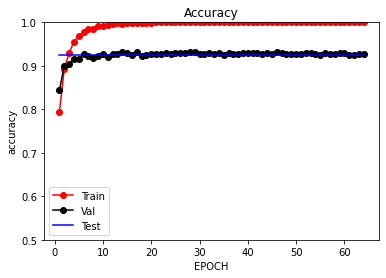

In [23]:
#Running NN

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers #for l1 or l2 regularizers
from keras.callbacks import EarlyStopping #stop training when monitored argument stops decreasing/increasing
import time

EPOCHS = 300
L1 = 0
L2 = 1e-4
BATCH_SIZE = 1024
LEARNING_RATE = 1e-4
LAYER1_NODES = 500
LAYER2_NODES = 500

start = time.time()
(trainX, valX, testX) = transform_dataset(StandardScaler(), nn_x_train, nn_x_validation, test_x)
model = Sequential([
    #input to first hidden layer
    Dense(units = LAYER1_NODES, input_dim = INPUT_NODES,
          activation = 'relu',
          kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)
          ),
    
    #first hidden layer to second hidden layer
    Dense(units = LAYER2_NODES, input_dim = LAYER1_NODES, 
          activation = 'relu',
          kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)
          ),
    
    #second hidden layer to output
    Dense(units = OUTPUT_NODES, input_dim = LAYER2_NODES, activation = 'softmax'),
    ])

# compile models with the learning rates set
opt = optimizers.adam(learning_rate = LEARNING_RATE)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

history = model.fit(trainX, nn_y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data = (valX, nn_y_validation), verbose = 0,
          callbacks = [EarlyStopping(monitor='val_accuracy', patience=50)]) 

#evaluate model on test set
_, accuracy = model.evaluate(testX, test_y_01, verbose = 0)
end = time.time()
time_taken = end - start

# print the summary of neural network model
print(model.summary())

# plot the changes in cost and accuracy of training and validation data
train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
ep = list(range(1,len(train_acc)+1))

plt.plot(ep, train_acc, 'ro-', label = 'Train')
plt.plot(ep, validation_acc, 'ko-', label = 'Val')
plt.plot(ep, [accuracy]*len(ep), 'b-', label = 'Test')
plt.xlabel('EPOCH')
plt.ylabel('accuracy')
plt.ylim(0.5, 1)
plt.title('Accuracy')
plt.legend()

Test Data Accuracy: 0.924
Time taken: 2296.48 seconds


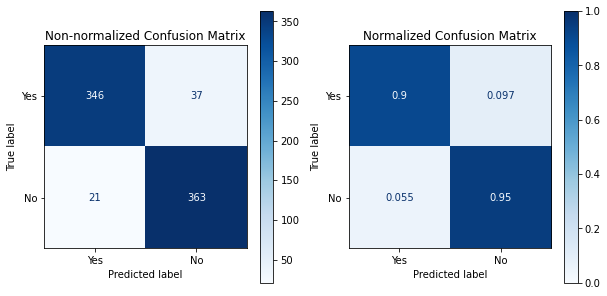

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# obtain predictions from model
test_y_pred_01 = model.predict_classes(testX, verbose = 0)

# convert the float values of test_y_pred_01 into a list of predictions 'Yes' or 'No'
test_y_pred = []
for i in range(len(test_y_pred_01)):
    if test_y_pred_01[i] == 1:
        test_y_pred.append('Yes')
    else:
        test_y_pred.append('No')
        
# plot confusion matrix and record relevant data
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result['Feed-Forward NN'] = {'Time' : time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)
    
print('Test Data Accuracy:', '{:.3f}'.format(accuracy))
print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

For some reason, even after all the parameter tuning I have done, the resulting model still seems to be overfitting the data. It is possible that this model that I have trained is the best possible model and that it is impossible to train a Neural Network model that has a predictive value of more than 95\% on the test data.

However, as mentioned previously, there is almost an infinite amount of configurations and architecture designs in building a Neural Network model. It is more possible that there is a better hidden layer design, or better tuning of parameters that I have overlooked that can produce a model with a higher predictive value.

### Model 2: Convolutional Neural Network

The process of training a Convolutional Neural Network is not much different from a Feed-Forward one, both take in image pixels as inputs, goes through some hidden layers, and produces output predictions. The difference, however, is that the inputs are required to pass through in the shape of the standardized images (ie. 128 $\times$ 128) pixels. These inputs then go through a set/sets of convolutional and pooling layers. The convolutional layers contain filters that aid in pattern recognition, and the pooling layers "collect" important patterns in images and help in lowering the computational costs. After passing through the series of convolutional and pooling layers, our data (in the form of 2D matrices) is flattened into a 1D vector and passed through the same process of Feed-Forward Neural Network, ie. going through hidden layers and finally producing outputs.

Overall, other than the following list of things to experiment on, the rest of the process to improve a Convolutional Neural Netowrk model is the same as the Feed-Forward case (eg. data augmentation, learning rate and batch size tuning).
* Number of filters in each convolutional layer
* Filter size in each convolutional layer
* Number of convolutional and pooling layers
* Pool size in pooling layer  

The above parameters are experimented via trial and error instead of a grid search like the previous section. Hence, there will not be any analysis on how each parameter effects the model, instead we will move on straight to the best possible model I have achieved.

### Training Best (?) Possible Convolutional Neural Network in Keras


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)           

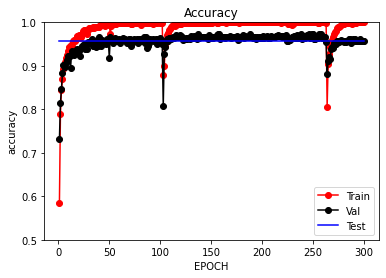

In [25]:
(NUM_OF_DATA, INPUT_NODES) = train_x.shape
OUTPUT_NODES = 2

EPOCHS = 300
BATCH_SIZE = 1024
L1 = 0
L2 = 1e-2
LEARNING_RATE = 1e-4
       
# splitting training data into train and validation data sets
(nn_x_train, nn_x_validation, nn_y_train, nn_y_validation) = train_test_split(train_x, train_y, train_size = 0.8, test_size = 0.2, random_state = 1)

# increase number of training data
(nn_x_train, nn_y_train) = data_augmentation.increase_data(nn_x_train, nn_y_train, (128,128,3))

# convert test and training y values from 'Yes' or 'No' to [1,0] or [0,1] respectively
onehot_encoder = OneHotEncoder(sparse=False)
nn_y_train = nn_y_train.reshape(len(nn_y_train),1)
nn_y_train = onehot_encoder.fit_transform(nn_y_train)
nn_y_validation = nn_y_validation.reshape(len(nn_y_validation),1)
nn_y_validation = onehot_encoder.fit_transform(nn_y_validation)
test_y_01 = test_y_true.reshape(len(test_y_true),1)
test_y_01 = onehot_encoder.fit_transform(test_y_01)

# changing input shape of training, validation, and test data
nn_x_train = nn_x_train.reshape((len(nn_x_train), 128, 128, 3))
nn_x_validation = nn_x_validation.reshape((len(nn_x_validation), 128, 128, 3))
test_x = test_x.reshape((len(test_x), 128, 128, 3))

# build 2d-convolutional neural network
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import regularizers #for l1 or l2 regularizers
from keras.callbacks import EarlyStopping #stop training when monitored argument stops decreasing/increasing

start = time.time()
model = Sequential()
# adding first 2d-convolutional layer
model.add(Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = (128,128,3),
                 kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
# adding pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))
# adding second 2d-convolutional layer
model.add(Conv2D(64, kernel_size = (3,3), activation = "relu",
                  kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
# adding pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))
# adding third 2d-convolutional layer
model.add(Conv2D(128, kernel_size = (3,3), activation = "relu",
                  kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
# adding pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))
# flatten convolutional layers, move to dense layer
model.add(Flatten())
# adding first dense layer
model.add(Dense(units = 64, activation = "relu", kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
# adding second dense layer
model.add(Dense(units = 32, activation = "relu", kernel_regularizer = regularizers.l1_l2(l1 = L1, l2 = L2)))
# adding output layer
model.add(Dense(units = OUTPUT_NODES, activation = "softmax"))

# compile models with the learning rates set
opt = optimizers.adam(learning_rate = LEARNING_RATE)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

history = model.fit(nn_x_train, nn_y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data = (nn_x_validation, nn_y_validation), verbose = 0,
          callbacks = [EarlyStopping(monitor='val_loss', patience=20)]) 

#evaluate model on test set
_, accuracy = model.evaluate(test_x, test_y_01, verbose = 0)
end = time.time()
time_taken = end - start

# print the summary of neural network model
print(model.summary())

# plot the changes in cost and accuracy of training and validation data
train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
ep = list(range(1,len(train_acc)+1))

plt.plot(ep, train_acc, 'ro-', label = 'Train')
plt.plot(ep, validation_acc, 'ko-', label = 'Val')
plt.plot(ep, [accuracy]*len(ep), 'b-', label = 'Test')
plt.xlabel('EPOCH')
plt.ylabel('accuracy')
plt.ylim(0.5, 1)
plt.title('Accuracy')
plt.legend()

Test Data Accuracy: 0.958
Time taken: 76595.44 seconds


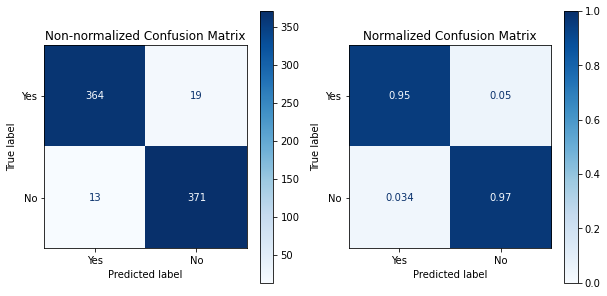

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# obtain predictions from model
test_y_pred_01 = model.predict_classes(test_x, verbose = 0)

# convert the float values of test_y_pred_01 into a list of predictions 'Yes' or 'No'
test_y_pred = []
for i in range(len(test_y_pred_01)):
    if test_y_pred_01[i] == 1:
        test_y_pred.append('Yes')
    else:
        test_y_pred.append('No')
        
# plot confusion matrix and record relevant data
fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
        classification_result['Convolutional NN'] = {'Time' : time_taken,
                                     'True Positive' : confmat[0][0],
                                     'True Negative' : confmat[1][1],
                                     'False Positive' : confmat[1][0],
                                     'False Negative' : confmat[0][1]}
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)
        
print('Test Data Accuracy:', '{:.3f}'.format(accuracy))
print('Time taken:', round(time_taken,2), 'seconds')

##### Notes:

1. Convolutional Neural Networks are generally better models for image recognition/classification since they take into account the spatial patterns within images as compared to Feed-Forward Neural Networks.

2. Overall, this model has performed slightly better than the previous Feed-Forward model.

3. There are other possible ways that might improve the predictive value of a deep learning model, eg. using batch normalization, model ensembles etc that isn't experimented on here. Some useful resources on those are in the reference section.

## Time and Accuracy Comparisons

The following figure is used to compare the difference in error rate, false positive rate, false negative rate, and time of each of the used method.

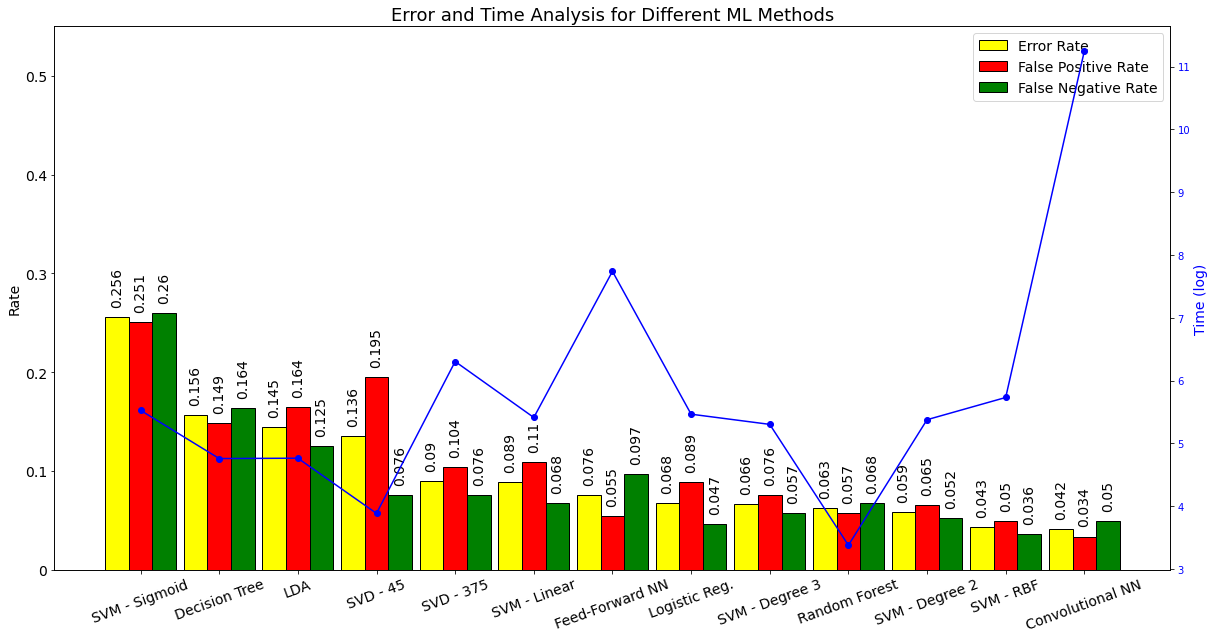

In [41]:
df = pd.DataFrame.from_dict(classification_result, orient = 'index')
df = df.reset_index()
total_sum = df['True Positive'] + df['True Negative'] + df['False Negative'] + df['False Positive']
df = df.assign(ErrorRate = (df['False Negative'] + df['False Positive']) / total_sum,
              TP_rate = df['True Positive'] / (df['True Positive'] + df['False Negative']),
              TN_rate = df['True Negative'] / (df['True Negative'] + df['False Positive']),
              FP_rate = df['False Positive'] / (df['True Negative'] + df['False Positive']),
              FN_rate = df['False Negative'] / (df['True Positive'] + df['False Negative']))
df = df.rename(columns = {'index' : 'Method', 'ErrorRate' : 'Error %', 'TP_rate' : 'True Positive %',
                         'TN_rate' : 'True Negative %', 'FP_rate' : 'False Positive %', 'FN_rate' : 'False Negative %'})
df = df.sort_values('Error %', ascending = False)

ind = np.arange(len(df))
width = 0.3

method = np.asarray(df['Method'])
time_taken = np.asarray(df['Time'])
fp = np.asarray(df['False Positive %'])
fn = np.asarray(df['False Negative %'])
err = np.asarray(df['Error %'])

fig, ax1 = plt.subplots(figsize = (20,10))
ax1.bar(ind - width, err, width,color = 'yellow', edgecolor = 'black')
ax1.bar(ind, fp, width, color = 'red', edgecolor = 'black')
ax1.bar(ind + width, fn, width, color = 'green', edgecolor = 'black')
ax1.legend(['Error Rate', 'False Positive Rate', 'False Negative Rate'], fontsize = 14)
ax1.set_ylim(0,0.55)
ax1.set_ylabel('Rate', fontsize = 14)
ax1.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize = 14)
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(method, rotation = 20, fontsize = 14)
ax1.set_title('Error and Time Analysis for Different ML Methods', fontsize = 18)

for i in range(len(df)):
    ax1.text(ind[i] - width, err[i] + 0.01, str(round(err[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')
    ax1.text(ind[i], fp[i] + 0.01, str(round(fp[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')
    ax1.text(ind[i] + width, fn[i] + 0.01, str(round(fn[i], 3)), 
             ha = 'center', va = 'bottom', size = 14, rotation = 'vertical')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('Time (log)', color=color, fontsize = 14)  # we already handled the x-label with ax1
ax2.plot(method, np.log(time_taken), 'o-b')
# ax2.set_ylim(0,1300)
# ax2.set_yticklabels(list(range(0,1201,200)), fontsize = 14)
ax2.tick_params(axis='y', labelcolor=color)

## Key Takeaways

1. Effect of having large number of data:
 - It is obvious that if we have more training data, the training times will increase, but sometimes, this leads to an improved in predictive accuracy of the trained model which makes the long training times worth the wait.
 - However, this is only true for the Neural Network cases. Other methods such as SVM ends up taking so much computing power and time that they are unable to produce any resulting models on my laptop.
 - In other words, deep learning/neural networks thrive under the large amounts of data (only linear increase in training time), but the same cannot be said for the other methods.
 
2. Effect of using different modes of data:
 - I had initially started all these experimentations using images that are standardized into 'P' formats, but the results did not bring me much satisfaction.
 - After switching the images into the 'RGB' format, all classification methods have shown improvements of around 3-5\%.

3. Time comparisons:
 - Methods like the RBF kernel SVM, the SVD classifier, and random forests managed to produce really great results at a really short period of time.
 - Neural networks on the other hand, take a really long time to train, even though they are capable of producing equally great results.
 
4. Something else that can improve the predictive accuracies of the above methods is increasing the size and mode of the images, eg. standardizing each image to a size of 256 $\times$ 256 pixels with the mode being RGB or RGBA.

## References and Resources

Plots:
* Plotting confusion matrix using Scikit-Learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

* Plotting confusion matrix using Scikit-Learn: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

* Plotting Confusion Matrix side by side: https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side

* Making subplots using Matplotlib: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html

* Making barchart using Matplotlib: https://matplotlib.org/examples/api/barchart_demo.html

SVM:
* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/svm.html

* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

* Kernel Selection in SVM via StackExchange: https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm

* Parameter Tuning in SVM: https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

* The Kernel Trick in Support Vector Classification: https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f#:~:text=The%20%E2%80%9Ctrick%E2%80%9D%20is%20that%20kernel,the%20data%20by%20these%20transformed

* Aarti Singh on SVM: http://www.cs.cmu.edu/~aarti/Class/10601/slides/svm_11_22_2011.pdf

Logistic Regression:
* Logistic Regression by RealPython: https://realpython.com/logistic-regression-python/

* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

* Regularization for Logistic Regression by Knime: https://www.knime.com/blog/regularization-for-logistic-regression-l1-l2-gauss-or-laplace#:~:text=Regularization%20for%20Logistic%20Regression%3A%20L1%2C%20L2%2C%20Gauss%20or%20Laplace%3F,-Mon%2C%2003%2F12&text=Regularization%20can%20be%20used%20to%20avoid%20overfitting.&text=In%20other%20words%3A%20regularization%20can,from%20overfitting%20the%20training%20dataset

* Why use regularization: https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul

LDA:
* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Logistic Regression vs LDA:
* StackExchange: https://stats.stackexchange.com/questions/95247/logistic-regression-vs-lda-as-two-class-classifiers

Random Forest
* DataCamp explanations: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

* Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* Implementation and explanation of Random Forest: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

* Decision Trees by Wikipedia: https://en.wikipedia.org/wiki/Decision_tree_learning

* How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

Feed Forward Neural Network:
* Tensorflow Tutorial by AdventuresInMachineLearning: https://adventuresinmachinelearning.com/python-tensorflow-tutorial/

* Tensorflow Tutorial by AdventuresInMachineLearning: https://adventuresinmachinelearning.com/improve-neural-networks-part-1/

* Tensorflow Regularization by Ritchie Ng: https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/

* Backpropogation by Wikipedia: https://en.wikipedia.org/wiki/Backpropagation

* Early Stopping to Avoid Overtraining by MachineLearningMastery: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/

* Techniques to Prevent Overfitting by KDnuggets: https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html

* Neural Network Architecture by StackExchange: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer

* Pruning in Neural Network by TowardsDataScience: https://towardsdatascience.com/pruning-deep-neural-network-56cae1ec5505

* How to Train Neural Network Faster with Optimizers by TowardsDataScience: https://towardsdatascience.com/how-to-train-neural-network-faster-with-optimizers-d297730b3713

* Fluctuation in Cost and Accuracy by StackExchange: https://stats.stackexchange.com/questions/345990/why-does-the-loss-accuracy-fluctuate-during-the-training-keras-lstm

* Fluctuation in Validation Accuracy by StackExchange: https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating

* Keras Tutorial by MachineLearningMaster: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

* How to Get Predicted Values in Keras by StackOverflow: https://stackoverflow.com/questions/45587378/how-to-get-predicted-values-in-keras

* Regularization in Neural Networks using Keras by AnalyticsVidhya: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

* Why is Neural Network Training Not Working: http://theorangeduck.com/page/neural-network-not-working

* Data Scaling by MachineLearningMastery: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

Convolutional Neural Network:
* A Comprehensive Guide to Neural Networks by TowardsDataScience: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

* Convolutional Neural Network Tutorial in Keras by TowardsDataScience: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

* The Best Explanation of Convolutional Neural Network by Medium: https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8#:~:text=Pooling%20Layers,building%20block%20of%20a%20CNN.&text=Its%20function%20is%20to%20progressively,on%20each%20feature%20map%20independently.

* Ensemble Neural Networks by MachineLearningMastery: https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/